# LMI and LI

<hr>

**Module load and IBTRACs read in**

In [1]:
# close warming info
import warnings
warnings.filterwarnings("ignore")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
#
from   netCDF4                 import Dataset
from   matplotlib              import gridspec
from   scipy.optimize          import curve_fit
from   mpl_toolkits.basemap    import Basemap
from   datetime                import datetime, timedelta
from   termcolor               import cprint
from   matplotlib.patches      import Polygon
from   matplotlib.colors       import BoundaryNorm
from   matplotlib.colorbar     import Colorbar
from sklearn import preprocessing
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import pandas                  as pd
import statsmodels.formula.api as sm
import matplotlib.mlab         as mlab
import matplotlib.colors       as mcolors
import matplotlib, copy, scipy, scipy.stats, statsmodels, random, glob
import geopy.distance
import statsmodels.api as sm
from   statsmodels.stats.outliers_influence import summary_table
from   lmfit                   import Model, Parameters
import cdsapi
import atmos
from pcmin_fullterm import pcmin
from patsy import dmatrices
#from pcmin import pcmin
#from tcpi_allterm import pcmin, pcmin3_kflag

# define the year period
START_YEAR    = 1982
END_YEAR      = 2019
INDEX_year    = np.arange(START_YEAR,END_YEAR+1)
# basin names
BASIN_NAMEs   = ['NA','EP','WP','NI','SI','SP','NH','SH','GB']
# Creat CAT_KT that contains the upper and lower winds for different categories
tmp = np.zeros((2,7))
tmp[0,0] = -1000.
tmp[1,0] = 33.
tmp[0,1] = 34.
tmp[1,1] = 63.
tmp[0,2] = 64.
tmp[1,2] = 82.
tmp[0,3] = 83.
tmp[1,3] = 95.
tmp[0,4] = 96.
tmp[1,4] = 112.
tmp[0,5] = 113.
tmp[1,5] = 136.
tmp[0,6] = 137.
tmp[1,6] = 10000.
CAT_KT = pd.DataFrame(tmp,index=['LOWER','UPPER'],columns=['TD','TS','CAT1','CAT2','CAT3','CAT4','CAT5'])
#
ibt = pd.read_csv('./ibtracs.ALL.list.v04r00.csv',skiprows=[1],keep_default_na=False,na_values=[' '])
#C find the duration from INTENSITY_START to INTENSITY_END, duration unit is hour
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

<hr>

**Global function define**

**DEF: trend and CI**

In [2]:
from scipy.stats import t
from scipy.signal import detrend

def get_trend_and_ci_weight(X,Y,sample_weight):
    X = np.asarray(X)
    X_ORIGINAL = X
    Y = np.asarray(Y)
    sample_weight = np.asarray(sample_weight)
    mask = ~np.isnan(X) & ~np.isnan(Y)
    X = X[mask]
    Y = Y[mask]
    sample_weight = sample_weight[mask]
    
    X = sm.add_constant(X)
    res = sm.WLS(Y,X,sample_weight).fit()
    st, data, ss2 = summary_table(res, alpha=0.05)
    fittedvalues = data[:,2]
    predict_mean_se  = data[:,3]
    predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
    p=res.pvalues[1]
    slope = res.params[1]
    intercept = res.params[0]
    fittedvalues = slope*X_ORIGINAL + intercept
    conf_int_slope = res.params[1]-res.conf_int()[1,0]
    if check_autocorrelation_durbin_watson( Y) == False :
        df = len(Y) - 2
    else:
        lagauto = abs(pd.Series(detrend(Y)).autocorr(lag=1))
        df = (len(Y) - 2) * ( (1-lagauto)/(1+lagauto) )
    return X_ORIGINAL, fittedvalues,slope,res.bse[1] * t.ppf(1 - 0.025, df=df),p

In [3]:
from scipy.stats import t
from scipy.signal import detrend

def get_trend_and_ci_weight_CITHRES(X,Y,sample_weight,CITHRES):
    X = np.asarray(X)
    X_ORIGINAL = X
    Y = np.asarray(Y)
    sample_weight = np.asarray(sample_weight)
    mask = ~np.isnan(X) & ~np.isnan(Y)
    X = X[mask]
    Y = Y[mask]
    sample_weight = sample_weight[mask]
    
    X = sm.add_constant(X)
    res = sm.WLS(Y,X,sample_weight).fit()
    st, data, ss2 = summary_table(res, alpha=1-CITHRES)
    fittedvalues = data[:,2]
    predict_mean_se  = data[:,3]
    predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
    p=res.pvalues[1]
    slope = res.params[1]
    intercept = res.params[0]
    fittedvalues = slope*X_ORIGINAL + intercept
    conf_int_slope = res.params[1]-res.conf_int()[1,0]
    if check_autocorrelation_durbin_watson( Y) == False :
        df = len(Y) - 2
    else:
        lagauto = abs(pd.Series(detrend(Y)).autocorr(lag=1))
        df = (len(Y) - 2) * ( (1-lagauto)/(1+lagauto) )
    return X_ORIGINAL, fittedvalues,slope,res.bse[1] * t.ppf(1 - (1-CITHRES)/2, df=df)

In [4]:
from scipy.signal import detrend
from statsmodels.stats.stattools import durbin_watson
def check_autocorrelation_durbin_watson(resids):
    xxx = detrend(resids)
    dw_output = durbin_watson(xxx,axis=0)
    if dw_output>=1.427 and dw_output<=4-1.427:
        is_autocorrelated=False
    else:
        is_autocorrelated=True
    return is_autocorrelated
def check_autocorrelation_plot(var):
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(detrend(var))

In [5]:
def poisson_reg(X,Y):
    X = np.asarray(X)
    Y = np.asarray(Y)
    exog, endog = sm.add_constant(X), Y
    res = sm.GLM(endog, exog, family=sm.families.Poisson()).fit()
    ci   = (abs(res.params[1] - res.conf_int()[1][0]) + abs(res.params[1] - res.conf_int()[1][1]))/2
    p=res.pvalues[1]
    mean = res.params[1]
    pred = res.predict()
    #print(res.summary())
    
    return pred, mean, ci, p

**DEF: moving speed and LMI to LI trajectory length**

In [6]:
def CALC_MOVING_SPEED(tmp_lat,tmp_lon):
    tmp_u  = np.nan * np.zeros(shape=tmp_lat.shape)
    tmp_v  = np.nan * np.zeros(shape=tmp_lat.shape)
    tmp_uv = np.nan * np.zeros(shape=tmp_lat.shape)
    tmp_tra=          np.zeros(shape=tmp_lat.shape)
    for RRR in range(len(tmp_lat)-1):
        coords_1 = (tmp_lat[RRR+1], tmp_lon[RRR])
        coords_2 = (tmp_lat[RRR]  , tmp_lon[RRR])
        # poleward speed is positive
        tmp_v[RRR]    = np.sign(np.abs(tmp_lat[RRR+1])-np.abs(tmp_lat[RRR]))*geopy.distance.vincenty(coords_1, coords_2).m/3./3600.
        coords_1 = (tmp_lat[RRR  ], tmp_lon[RRR  ])
        coords_2 = (tmp_lat[RRR+1], tmp_lon[RRR+1])
        ##
        # here RRR+1 means we calculate the velocity and distance moved in the PAST 3 hrs
        ##
        tmp_tra [RRR+1] = geopy.distance.vincenty(coords_1, coords_2).km
        tmp_uv  [RRR+1] = tmp_tra [RRR+1]*1e3/3./3600.
        # westward speed is positive
        tmp_u[RRR+1]    = -np.sign(tmp_lon[RRR+1]-tmp_lon[RRR])*np.sqrt(tmp_uv[RRR+1]**2-tmp_v[RRR+1]**2)
    return tmp_u,tmp_v,tmp_uv,tmp_tra

**DEF: bootstrap**

In [7]:
def bootstrapping_compare_mean_CI_star(sample1,sample2,CI_THRES):
    sample1 = np.asarray(sample1)
    sample2 = np.asarray(sample2)
    DIFF_MEAN_RESAMPLE = []
    for LLL in range(10000):
        resample1=np.random.choice(sample1,size=sample1.shape,replace=True)
        resample2=np.random.choice(sample2,size=sample2.shape,replace=True)
        DIFF_MEAN_RESAMPLE.extend([np.nanmean(resample2) - np.nanmean(resample1)])
    output_ci1 = scipy.stats.scoreatpercentile(DIFF_MEAN_RESAMPLE,(100.-CI_THRES)/2.)
    output_ci2 = scipy.stats.scoreatpercentile(DIFF_MEAN_RESAMPLE,100.-(100.-CI_THRES)/2.)
    return np.nanmean(DIFF_MEAN_RESAMPLE)-output_ci1,output_ci2-np.nanmean(DIFF_MEAN_RESAMPLE),np.nanmean(DIFF_MEAN_RESAMPLE)

**DEF: bootstrap2**

In [8]:
def bootstrapping_compare_halfchange(sample1,sample2):
    sample1_0 = np.asarray(sample1[:len(sample1)//2])
    sample1_1 = np.asarray(sample1[len(sample1)//2:])
    DIFF_MEAN_RESAMPLE_1 = []
    for LLL in range(100):
        resample1_0=np.random.choice(sample1_0,size=sample1_0.shape,replace=True)
        resample1_1=np.random.choice(sample1_1,size=sample1_0.shape,replace=True)
        DIFF_MEAN_RESAMPLE_1.extend([np.nanmean(resample1_1) - np.nanmean(resample1_0)])
    sample2_0 = np.asarray(sample2[:len(sample2)//2])
    sample2_1 = np.asarray(sample2[len(sample2)//2:])
    DIFF_MEAN_RESAMPLE_2 = []
    for LLL in range(100):
        resample2_0=np.random.choice(sample2_0,size=sample2_0.shape,replace=True)
        resample2_1=np.random.choice(sample2_1,size=sample2_0.shape,replace=True)
        DIFF_MEAN_RESAMPLE_2.extend([np.nanmean(resample2_1) - np.nanmean(resample2_0)])
    
    DIFF_MEAN_RESAMPLE_1 = np.asarray(DIFF_MEAN_RESAMPLE_1)
    DIFF_MEAN_RESAMPLE_2 = np.asarray(DIFF_MEAN_RESAMPLE_2)
    plt.hist([DIFF_MEAN_RESAMPLE_1,DIFF_MEAN_RESAMPLE_2])
    stats,p = scipy.stats.ttest_ind(DIFF_MEAN_RESAMPLE_1,DIFF_MEAN_RESAMPLE_2)
    return np.nanmean(DIFF_MEAN_RESAMPLE_2),np.nanmean(DIFF_MEAN_RESAMPLE_1),np.nanmean(DIFF_MEAN_RESAMPLE_2)-np.nanmean(DIFF_MEAN_RESAMPLE_1),p

**chi2 poisson distribution fit text**

In [9]:
def chi2_poisson_fit(data):
    
    from scipy.optimize import curve_fit
    from scipy.special import factorial
    from scipy.stats import poisson

    # the bins should be of integer width, because poisson is an integer distribution
    bins = np.arange(np.nanmin(data),np.nanmax(data)+2) - 0.5
    entries, bin_edges, patches = plt.hist(data, bins=bins, density=True, label='Data')

    # calculate bin centres
    bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    def fit_function(k, lamb):
        '''poisson function, parameter lamb is the fit parameter'''
        return poisson.pmf(k, lamb)

    # fit with curve_fit
    parameters, cov_matrix = curve_fit(fit_function, bin_middles, entries,p0=[5])
    
    # plot poisson-deviation with fitted parameter
    x_plot = np.arange(np.nanmin(data), np.nanmax(data)+1)

    #_=plt.plot(
    #    x_plot,
    #    fit_function(x_plot, *parameters),
    #    marker='o', linestyle='',
    #    label='Fit result',
    #)
    #_=plt.legend()

    Nexp = fit_function(bin_middles, *parameters)
    entries = entries * len(Y)
    Nexp    = Nexp    * len(Y)
    r = entries - Nexp
    chisq = np.sum(r**2/Nexp)
    df = len(data) - 2
    return print("chisq =",chisq,"df =",df)

<hr>

**Data pre processing**

The filters are:<br>
1. Time from 1982-2019
1. Only official records at 00 03 06 09 12 15 18 21 UTC
1. LMI >= 64 kt
1. At least 24-h consecutive records before and after LMI
1. within 40 NS
1. only consider the landfall after the last LMI

**newbt** is the new cleaned variable <br>
**newbt_lf** is the new cleaned landfall TCs <br>
**newbt_nonlf** is the new cleaned non landfall TCs <br>


In [10]:
def index_for_last_max(x):
    x=np.asarray(x)
    return len(x)-np.nanargmax(x[::-1])-1

In [11]:
def mark_landfall(x):
    DIST2LAND = x.DIST2LAND.values[:]
    WIND      = x.USA_WIND.values[:]
    # use 1 to mark landfall time after the last LMI
    LF_MARKER = np.zeros(shape=DIST2LAND.shape)
    for RRR in range(index_for_last_max(WIND),len(WIND)):
        if DIST2LAND[RRR]==0 and DIST2LAND[RRR-1]>0.:
            LF_MARKER[RRR] = 1
    x['LF_MARKER'] = list(LF_MARKER)
    return x

In [12]:
def lf_after_lmi(x):
    RRR_LMI= x.iloc[::-1].USA_WIND.idxmax()
    tmp_x=x[x.LF_MARKER==1]
    RRR_LF = tmp_x.USA_WIND.idxmax()
    output_wind = [];
    if RRR_LF-RRR_LMI >= 0 :
        return True
    else:
        return False
        print("Strongest LI before the last LMI!!!!:",x.SID.values[0])

In [13]:
newbt = ibt[(ibt.SEASON >= START_YEAR)&(ibt.SEASON <= END_YEAR)]
newbt = newbt[newbt.BASIN!='SA']
newbt = newbt[np.abs(newbt.USA_LAT) <= 40]
newbt = newbt[
              newbt.ISO_TIME.str.contains('00:00:00') | 
              newbt.ISO_TIME.str.contains('03:00:00') | 
              newbt.ISO_TIME.str.contains('06:00:00') | 
              newbt.ISO_TIME.str.contains('09:00:00') | 
              newbt.ISO_TIME.str.contains('12:00:00') | 
              newbt.ISO_TIME.str.contains('15:00:00') | 
              newbt.ISO_TIME.str.contains('18:00:00') |
              newbt.ISO_TIME.str.contains('21:00:00')
             ]
newbt = newbt.groupby('SID').filter(lambda x: np.nanmax(x.USA_WIND) >= CAT_KT.CAT1.LOWER)
newbt = newbt[~np.isnan(newbt.USA_WIND.values)]
newbt = newbt.groupby('SID').apply (lambda x: mark_landfall(x))
# lf
newbt_lf     = newbt   .groupby('SID').filter(lambda x: np.any(x.LF_MARKER == 1))
newbt_lf     = newbt_lf.groupby('SID').filter(lambda x: lf_after_lmi(x))
# non lf
newbt_nonlf  = newbt   .groupby('SID').filter(lambda x: np.all(x.LF_MARKER != 1))

**Check annual number**

In [14]:
TABLE = pd.DataFrame(index=list(INDEX_year)+list(['Total']),columns=BASIN_NAMEs)
for YYY,YEAR in enumerate(INDEX_year):
    for BBB,BASIN in enumerate(BASIN_NAMEs[:-3]):
        TABLE.iloc[YYY,BBB] = newbt_lf[(newbt_lf.SEASON==YEAR)&(newbt_lf.BASIN==BASIN)].groupby('SID').ngroups
TABLE.iloc[-1,0:6] = np.sum(TABLE.iloc[:-1,0:6])
TABLE.iloc[:,6] = np.sum(TABLE.iloc[:,:4],axis=1).astype(int)
TABLE.iloc[:,7] = np.sum(TABLE.iloc[:,4:6],axis=1).astype(int)
TABLE.iloc[:,8] = np.sum(TABLE.iloc[:,6:8],axis=1).astype(int)
TABLE

,NA,EP,WP,NI,SI,SP,NH,SH,GB
1982,0,1,13,2,2,1,16,3,19
1983,2,4,8,0,1,1,14,2,16
1984,2,4,4,2,3,1,12,4,16
1985,5,1,11,0,2,2,17,4,21
1986,1,3,7,0,1,2,11,3,14
1987,2,1,8,1,0,1,12,1,13
1988,4,2,6,1,2,2,13,4,17
1989,3,3,13,1,3,2,20,5,25
1990,1,2,15,1,1,1,19,2,21
1991,0,0,9,1,0,1,10,1,11


<hr>

## Fit linear / exponential / reciprocal decay to individual cases LMI->LF

In [15]:
def from_lmi_to_lf(x):
    RRR_LMI= x.iloc[::-1].USA_WIND.idxmax()
    tmp_x=x[x.LF_MARKER==1]
    RRR_LF = tmp_x.USA_WIND.idxmax()
    output_wind = [];
    
    if RRR_LF-RRR_LMI >= 1:
    
        pick = x[(x.index>=RRR_LMI)&(x.index<=RRR_LF)]
        output_wind = pick.USA_WIND.values[:]
        output_wind = np.asarray(output_wind)
        output_lat  = pick.USA_LAT.values[:]
        output_lat  = np.asarray(output_lat )
        output_lon  = pick.USA_LON.values[:]
        output_lon  = np.asarray(output_lon )
    
        return x.USA_WIND.max(),output_wind, x.SEASON.values[0],x[x.index==RRR_LMI].DIST2LAND.values[0],x.SID.values[0],output_lat,output_lon,x[x.index==RRR_LMI].BASIN.values[0]


In [16]:
VMAX_PMIN_SERIES = newbt_lf.groupby('SID').apply(lambda x: from_lmi_to_lf(x))
VMAX_PMIN_SERIES = VMAX_PMIN_SERIES.dropna()

In [17]:
speed_inverse = []
trajectory_inverse = []
trajectory_inverse_delta = []
lat_LMI_inverse = []
lat_LI_inverse  = []

for CCC in range(len(VMAX_PMIN_SERIES)):
    _,_,tmp_uv,tmp_tra = CALC_MOVING_SPEED(VMAX_PMIN_SERIES[CCC][5],VMAX_PMIN_SERIES[CCC][6])
    speed_inverse            .extend([np.nanmean(tmp_uv)])
    trajectory_inverse       .extend([np.nansum(tmp_tra)])
    trajectory_inverse_delta .append(tmp_tra) 
    lat_LMI_inverse          .extend([abs(VMAX_PMIN_SERIES[CCC][5][0])])
    lat_LI_inverse          .extend([abs(VMAX_PMIN_SERIES[CCC][5][-1])])
    
speed_inverse      = np.asarray(speed_inverse)
trajectory_inverse = np.asarray(trajectory_inverse)
lat_LMI_inverse    = np.asarray(lat_LMI_inverse)
lat_LI_inverse     = np.asarray(lat_LI_inverse)

In [18]:
time_inverse_calc = []
test = []

for CCC in range(len(VMAX_PMIN_SERIES)):
    # set what kind of translation speed you want: case variable or global mean
    #tmp = trajectory_inverse_delta[CCC]*1e3 / speed_inverse[CCC]
    tmp = trajectory_inverse_delta[CCC]*1e3 / np.nanmean(speed_inverse)
    
    tmptmp = []
    for RRR in range(0,len(trajectory_inverse_delta[CCC])):
        tmptmp.extend([np.nansum(tmp[:RRR+1])])
    
    time_inverse_calc.append(tmptmp)
    test.extend([tmptmp[-1]/3600])
        
test = np.asarray(test)

In [19]:
def func_linear(x,A,B):
    return A-B*x
def func_exp(x,A,B):
    return A*np.exp(-B*x)
def func_inverse(x,A,B):
    return 1./(1./A+B*x)
def func_latent(x,A,B,C):
    #return 1./(B/C-(B/C-1/A)*np.exp(-C*x))
    return 1./ ((1/A-B/C)*np.exp(-C*x) + B/C)
   #
def fit_decay(vmax_in,METHOD,year_in,t_in):
    epsilon = 1e-10
    vmax_in = np.asarray(vmax_in) * .51444
        #
    if METHOD == 'INVERSE':
        gmodel = Model(func_inverse)
        pars = Parameters()
        # change this line if want to vary LMI in the fit
        pars.add('A'  , value=vmax_in[0] , min=0.        , max=vmax_in[0]*2              , vary=False)
        pars.add('B'  , value=1e-7       , min=2e-8      , max=6e-7                      , vary=True)
        #
    if METHOD == 'EXP':
        gmodel = Model(func_exp)
        pars = Parameters()
        pars.add('A'  , value=vmax_in[0]   , min=0.        , max=vmax_in[0]*2              , vary=False)
        pars.add('B'  , value=1e-6         , min=0.        , max=0.0001                  , vary=True)
        #
    if METHOD == 'LATENT':
        gmodel = Model(func_latent)
        pars = Parameters()
        pars.add('A'  , value=vmax_in[0]   , min=0.        , max=vmax_in[0]*2              , vary=False)
        pars.add('B'  , value=1e-6         , min=0.        , max=0.0001                  , vary=True)
        pars.add('C'  , value=1e-6         , min=0.        , max=0.0001                  , vary=True)
        #
    result = gmodel.fit(vmax_in, pars, x=t_in,options={'maxiter': 1000} )
    vmax_pred = result.best_fit
    #
    A      = result.params.valuesdict()['A']
    B      = result.params.valuesdict()['B']
    if METHOD == 'LATENT':
        C  = result.params.valuesdict()['C']
    else:
        C  = np.nan
    if (result.params['B'].stderr == None):
        B_sd = np.nan
    else:
        B_sd   = result.params['B'].stderr 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(vmax_in, vmax_pred)
    rmse = np.sqrt(np.mean((vmax_pred-vmax_in)**2))
    bias = np.mean(vmax_pred-vmax_in)
    rmse_lf = abs(vmax_pred[-1]-vmax_in[-1])
    bias_lf =    (vmax_pred[-1]-vmax_in[-1])
    interp_vmax_in   = np.interp(np.linspace((np.arange(len(vmax_in))*6.*3600)[0],(np.arange(len(vmax_in))*6.*3600)[-1],11),(np.arange(len(vmax_in))*6.*3600),vmax_in  )
    interp_vmax_pred = np.interp(np.linspace(t_in[0],t_in[-1],11),t_in,vmax_pred)
    return r_value**2, p_value, rmse, bias, A, B, C,rmse_lf, bias_lf, year_in,interp_vmax_in,interp_vmax_pred,vmax_in,vmax_pred, B_sd

In [20]:
r_value_linear = []; p_value_linear = []; rmse_linear = []; bias_linear = []; A_linear = []; B_linear = []; C_linear = []; rmself_linear = []; biaslf_linear = []; year_linear = []; dur_linear = []; hl_linear = [];interp_vmax_in_linear =[];interp_vmax_pred_linear =[];vmax_in_linear =[];vmax_pred_linear =[];
r_value_exp    = []; p_value_exp    = []; rmse_exp    = []; bias_exp    = []; A_exp    = []; B_exp    = []; C_exp    = []; rmself_exp    = []; biaslf_exp    = []; year_exp    = []; dur_exp    = []; hl_exp    = [];interp_vmax_in_exp    =[];interp_vmax_pred_exp    =[];vmax_in_exp    =[];vmax_pred_exp    =[];
r_value_inverse= []; p_value_inverse= []; rmse_inverse= []; bias_inverse= []; A_inverse= []; B_inverse= []; C_inverse= []; rmself_inverse= []; biaslf_inverse= []; year_inverse= []; dur_inverse= []; hl_inverse= [];interp_vmax_in_inverse=[];interp_vmax_pred_inverse=[];vmax_in_inverse=[];vmax_pred_inverse=[];B_sd_inverse=[];
r_value_inverse_dis= []; p_value_inverse_dis= []; rmse_inverse_dis= []; bias_inverse_dis= []; A_inverse_dis= []; B_inverse_dis= []; C_inverse_dis=[]; rmself_inverse_dis= []; biaslf_inverse_dis= []; year_inverse_dis= []; dur_inverse_dis= []; hl_inverse_dis= [];interp_vmax_in_inverse_dis=[];interp_vmax_pred_inverse_dis=[];vmax_in_inverse_dis=[];vmax_pred_inverse_dis=[];B_sd_inverse_dis=[];
r_value_latent= []; p_value_latent= []; rmse_latent= []; bias_latent= []; A_latent= []; B_latent= []; C_latent= []; rmself_latent= []; biaslf_latent= []; year_latent= []; dur_latent= []; hl_latent= [];interp_vmax_in_latent=[];interp_vmax_pred_latent=[];vmax_in_latent=[];vmax_pred_latent=[];B_sd_latent=[];

#for CAT in range(len(tmp_vmax)):    #range(len(tmp_vmax)): [2,3,4]:  [0,1]:   
if 1==1:
    for CCC in range(len(VMAX_PMIN_SERIES)):
        
        r_value, p_value, rmse, bias, A, B, C, rmse_lf, bias_lf, year_lf, interp_vmax_in,interp_vmax_pred,vmax_in,vmax_pred, B_sd = fit_decay(VMAX_PMIN_SERIES[CCC][1],'EXP',VMAX_PMIN_SERIES[CCC][2],np.arange(len(VMAX_PMIN_SERIES[CCC][1])) * 3 * 3600)
        r_value_exp    .extend([r_value])
        p_value_exp    .extend([p_value]) 
        rmse_exp       .extend([rmse   ])
        bias_exp       .extend([bias   ])
        A_exp          .extend([A      ])
        B_exp          .extend([B      ])
        rmself_exp     .extend([rmse_lf])
        biaslf_exp     .extend([bias_lf])
        year_exp       .extend([year_lf])
        dur_exp        .extend([3*(len(VMAX_PMIN_SERIES[CCC][1])-1)])
        hl_exp         .extend([3*np.nanargmin(abs(VMAX_PMIN_SERIES[CCC][1]-VMAX_PMIN_SERIES[CCC][1][0]/2))])
        interp_vmax_in_exp   .append(interp_vmax_in)
        interp_vmax_pred_exp .append(interp_vmax_pred)
        vmax_in_exp      .append(vmax_in)
        vmax_pred_exp    .append(vmax_pred)
        #
        r_value, p_value, rmse, bias, A, B, C, rmse_lf, bias_lf, year_lf, interp_vmax_in,interp_vmax_pred,vmax_in,vmax_pred, B_sd = fit_decay(VMAX_PMIN_SERIES[CCC][1],'INVERSE',VMAX_PMIN_SERIES[CCC][2],np.arange(len(VMAX_PMIN_SERIES[CCC][1])) * 3 * 3600)
        r_value_inverse.extend([r_value])
        p_value_inverse.extend([p_value]) 
        rmse_inverse   .extend([rmse   ])
        bias_inverse   .extend([bias   ])
        A_inverse      .extend([A      ])
        B_inverse      .extend([B      ])
        B_sd_inverse   .extend([B_sd   ])
        rmself_inverse .extend([rmse_lf])
        biaslf_inverse .extend([bias_lf])
        year_inverse   .extend([year_lf])
        dur_inverse    .extend([3*(len(VMAX_PMIN_SERIES[CCC][1])-1)])
        hl_inverse     .extend([3*np.nanargmin(abs(VMAX_PMIN_SERIES[CCC][1]-VMAX_PMIN_SERIES[CCC][1]/2))])
        interp_vmax_in_inverse  .append(interp_vmax_in)
        interp_vmax_pred_inverse.append(interp_vmax_pred)
        vmax_in_inverse  .append(vmax_in)
        vmax_pred_inverse.append(vmax_pred)
        #
        r_value, p_value, rmse, bias, A, B, C, rmse_lf, bias_lf, year_lf, interp_vmax_in,interp_vmax_pred,vmax_in,vmax_pred, B_sd = fit_decay(VMAX_PMIN_SERIES[CCC][1],'INVERSE',VMAX_PMIN_SERIES[CCC][2],time_inverse_calc[CCC])
        r_value_inverse_dis.extend([r_value])
        p_value_inverse_dis.extend([p_value]) 
        rmse_inverse_dis   .extend([rmse   ])
        bias_inverse_dis   .extend([bias   ])
        A_inverse_dis      .extend([A      ])
        B_inverse_dis      .extend([B      ])
        B_sd_inverse_dis   .extend([B_sd   ])
        rmself_inverse_dis .extend([rmse_lf])
        biaslf_inverse_dis .extend([bias_lf])
        year_inverse_dis   .extend([year_lf])
        dur_inverse_dis    .extend([3*(len(VMAX_PMIN_SERIES[CCC][1])-1)])
        hl_inverse_dis     .extend([3*np.nanargmin(abs(VMAX_PMIN_SERIES[CCC][1]-VMAX_PMIN_SERIES[CCC][1]/2))])
        interp_vmax_in_inverse_dis  .append(interp_vmax_in)
        interp_vmax_pred_inverse_dis.append(interp_vmax_pred)
        vmax_in_inverse_dis  .append(vmax_in)
        vmax_pred_inverse_dis.append(vmax_pred)
        #
        r_value, p_value, rmse, bias, A, B, C, rmse_lf, bias_lf, year_lf, interp_vmax_in,interp_vmax_pred,vmax_in,vmax_pred, B_sd = fit_decay(VMAX_PMIN_SERIES[CCC][1],'LATENT',VMAX_PMIN_SERIES[CCC][2],np.arange(len(VMAX_PMIN_SERIES[CCC][1])) * 3 * 3600)
        r_value_latent.extend([r_value])
        p_value_latent.extend([p_value]) 
        rmse_latent   .extend([rmse   ])
        bias_latent   .extend([bias   ])
        A_latent      .extend([A      ])
        B_latent      .extend([B      ])
        C_latent      .extend([C      ])
        B_sd_latent   .extend([B_sd   ])
        rmself_latent .extend([rmse_lf])
        biaslf_latent .extend([bias_lf])
        year_latent   .extend([year_lf])
        dur_latent    .extend([3*(len(VMAX_PMIN_SERIES[CCC][1])-1)])
        hl_latent     .extend([3*np.nanargmin(abs(VMAX_PMIN_SERIES[CCC][1]-VMAX_PMIN_SERIES[CCC][1]/2))])
        interp_vmax_in_latent  .append(interp_vmax_in)
        interp_vmax_pred_latent.append(interp_vmax_pred)
        vmax_in_latent  .append(vmax_in)
        vmax_pred_latent.append(vmax_pred)
        #
B_exp = np.asarray(B_exp)*3600 # change the unit of B exp from /s to /hr
dur_exp = np.asarray(dur_exp)
B_exp[dur_exp==0] = np.nan

In [21]:
B_inverse = np.asarray(B_inverse)
dur_inverse = np.asarray(dur_inverse)
B_inverse[dur_inverse==0] = np.nan
speed_inverse[dur_inverse==0] = np.nan

**$y=V_o-Bt \quad$  $y=V_oe^{-Bt} \quad$   $y=\frac{1}{\frac{1}{V_o}+Bt}$**

In [22]:
def fit_test(AREA):
    tmp_r      = []
    tmp_rmse   = []
    tmp_bias   = []
    tmp_maelf  = []
    tmp_biaslf = []
    for CCC in range(len(VMAX_PMIN_SERIES)):
        if (VMAX_PMIN_SERIES[CCC][7] in AREA) & (dur_latent[CCC]>3): # dur_inverse[CCC]==3 means there is only one intensity reading during decay, ie having last LMI at landfall
            tmp_r      .extend([r_value_latent [CCC] ])
            tmp_rmse   .extend([rmse_latent    [CCC] ])
            tmp_bias   .extend([bias_latent    [CCC] ])
            tmp_maelf  .extend([rmself_latent  [CCC] ])
            tmp_biaslf .extend([biaslf_latent  [CCC] ])
    return np.round(np.nanmean(tmp_r),2),np.round(np.nanmean(tmp_rmse)),np.round(np.nanmean(tmp_bias)),np.round(np.nanmean(tmp_maelf)),np.round(np.nanmean(tmp_biaslf))

In [23]:
TABLE = pd.DataFrame(index=['r2','rmse (m s$^{-1}$)','bias (m s$^{-1}$)','mae (m s$^{-1}$) LF','bias (m s$^{-1}$) LF'],columns=['Global','NH','SH','WP','EP','NA','NI','SI','SP'])
for BBB,AREA in enumerate( [
    ['WP','EP','NA','NI','SI','SP'],
    ['WP','EP','NA','NI'],
    ['SI','SP'],
    ['WP'],
    ['EP'],
    ['NA'],
    ['NI'],
    ['SI'],
    ['SP'],
            ]):
    
    output1,output2,output3,output4,output5 = fit_test(AREA)
    TABLE.iloc[0,BBB] = output1
    TABLE.iloc[1,BBB] = output2
    TABLE.iloc[2,BBB] = output3
    TABLE.iloc[3,BBB] = output4
    TABLE.iloc[4,BBB] = output5

TABLE

,Global,NH,SH,WP,EP,NA,NI,SI,SP
r2,0.89,0.89,0.9,0.91,0.89,0.82,0.93,0.89,0.9
rmse (m s$^{-1}$),2,2,2,2,3,2,2,2,2
bias (m s$^{-1}$),-0,-0,-0,-0,-0,-0,-0,-0,-0
mae (m s$^{-1}$) LF,3,4,3,3,4,3,3,3,4
bias (m s$^{-1}$) LF,3,3,2,3,3,2,2,2,4


In [24]:
def fit_test(AREA):
    tmp_r      = []
    tmp_rmse   = []
    tmp_bias   = []
    tmp_maelf  = []
    tmp_biaslf = []
    for CCC in range(len(VMAX_PMIN_SERIES)):
        if (VMAX_PMIN_SERIES[CCC][7] in AREA) & (dur_inverse[CCC]>3): # dur_inverse[CCC]==3 means there is only one intensity reading during decay, ie having last LMI at landfall
            tmp_r      .extend([r_value_inverse_dis [CCC] ])
            tmp_rmse   .extend([rmse_inverse_dis    [CCC] ])
            tmp_bias   .extend([bias_inverse_dis    [CCC] ])
            tmp_maelf  .extend([rmself_inverse_dis  [CCC] ])
            tmp_biaslf .extend([biaslf_inverse_dis  [CCC] ])
    return np.round(np.nanmean(tmp_r),2),np.round(np.nanmean(tmp_rmse)),np.round(np.nanmean(tmp_bias)),np.round(np.nanmean(tmp_maelf)),np.round(np.nanmean(tmp_biaslf))

In [25]:
TABLE = pd.DataFrame(index=['r2','rmse (m s$^{-1}$)','bias (m s$^{-1}$)','mae (m s$^{-1}$) LF','bias (m s$^{-1}$) LF'],columns=['Global','NH','SH','WP','EP','NA','NI','SI','SP'])
for BBB,AREA in enumerate( [
    ['WP','EP','NA','NI','SI','SP'],
    ['WP','EP','NA','NI'],
    ['SI','SP'],
    ['WP'],
    ['EP'],
    ['NA'],
    ['NI'],
    ['SI'],
    ['SP'],
            ]):
    
    output1,output2,output3,output4,output5 = fit_test(AREA)
    TABLE.iloc[0,BBB] = output1
    TABLE.iloc[1,BBB] = output2
    TABLE.iloc[2,BBB] = output3
    TABLE.iloc[3,BBB] = output4
    TABLE.iloc[4,BBB] = output5

TABLE

,Global,NH,SH,WP,EP,NA,NI,SI,SP
r2,0.87,0.87,0.88,0.89,0.85,0.77,0.91,0.87,0.88
rmse (m s$^{-1}$),2,2,2,2,3,3,2,2,3
bias (m s$^{-1}$),-0,-0,0,-0,-0,-0,-0,0,0
mae (m s$^{-1}$) LF,3,3,3,3,4,4,4,3,4
bias (m s$^{-1}$) LF,2,2,2,2,2,-0,2,1,3


In [26]:
def fit_test(AREA):
    tmp_r      = []
    tmp_rmse   = []
    tmp_bias   = []
    tmp_maelf  = []
    tmp_biaslf = []
    for CCC in range(len(VMAX_PMIN_SERIES)):
        if (VMAX_PMIN_SERIES[CCC][7] in AREA) & (dur_exp[CCC]>3): # dur_inverse[CCC]==3 means there is only one intensity reading during decay, ie having last LMI at landfall
            tmp_r      .extend([r_value_exp [CCC] ])
            tmp_rmse   .extend([rmse_exp    [CCC] ])
            tmp_bias   .extend([bias_exp    [CCC] ])
            tmp_maelf  .extend([rmself_exp  [CCC] ])
            tmp_biaslf .extend([biaslf_exp  [CCC] ])
    return np.round(np.nanmean(tmp_r),2),np.round(np.nanmean(tmp_rmse)),np.round(np.nanmean(tmp_bias)),np.round(np.nanmean(tmp_maelf)),np.round(np.nanmean(tmp_biaslf))

In [27]:
TABLE = pd.DataFrame(index=['r2','rmse (m s$^{-1}$)','bias (m s$^{-1}$)','mae (m s$^{-1}$) LF','bias (m s$^{-1}$) LF'],columns=['Global','NH','SH','WP','EP','NA','NI','SI','SP'])
for BBB,AREA in enumerate( [
    ['WP','EP','NA','NI','SI','SP'],
    ['WP','EP','NA','NI'],
    ['SI','SP'],
    ['WP'],
    ['EP'],
    ['NA'],
    ['NI'],
    ['SI'],
    ['SP'],
            ]):
    
    output1,output2,output3,output4,output5 = fit_test(AREA)
    TABLE.iloc[0,BBB] = output1
    TABLE.iloc[1,BBB] = output2
    TABLE.iloc[2,BBB] = output3
    TABLE.iloc[3,BBB] = output4
    TABLE.iloc[4,BBB] = output5

TABLE

,Global,NH,SH,WP,EP,NA,NI,SI,SP
r2,0.88,0.88,0.88,0.9,0.87,0.77,0.92,0.88,0.89
rmse (m s$^{-1}$),2,2,2,2,3,3,2,2,2
bias (m s$^{-1}$),-0,-0,-0,-0,-0,0,-0,-0,-0
mae (m s$^{-1}$) LF,3,3,3,3,3,4,3,3,3
bias (m s$^{-1}$) LF,1,2,1,2,2,-0,1,1,2


<hr>

## Composite of obs. & pred. intenisty decay (FIGURE 2)

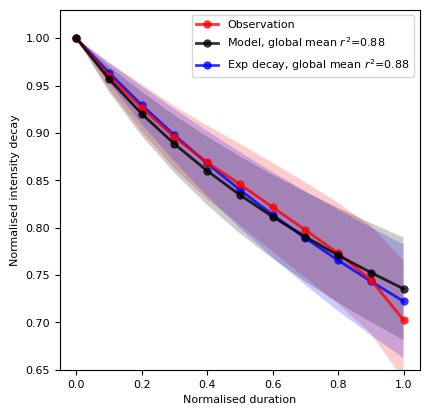

In [28]:
fig,ax=plt.subplots(1,1); fig.set_size_inches(4,4); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(100); 
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.35,hspace=0.3); fontsize = 8

norm_interp_vmax_in_inverse   = []
norm_interp_vmax_pred_inverse = []
norm_interp_vmax_pred_inverse_dis = []
for CCC in range(len(interp_vmax_in_inverse)):
    if dur_inverse[CCC]>=0:
        norm_interp_vmax_in_inverse  .append(interp_vmax_in_inverse          [CCC]/interp_vmax_in_inverse      [CCC][0])
        norm_interp_vmax_pred_inverse.append(interp_vmax_pred_inverse        [CCC]/interp_vmax_pred_inverse    [CCC][0])
        norm_interp_vmax_pred_inverse_dis.append(interp_vmax_pred_inverse_dis[CCC]/interp_vmax_pred_inverse_dis[CCC][0])
    
norm_interp_vmax_in_inverse       = np.asarray(norm_interp_vmax_in_inverse)
norm_interp_vmax_pred_inverse     = np.asarray(norm_interp_vmax_pred_inverse)
norm_interp_vmax_pred_inverse_dis = np.asarray(norm_interp_vmax_pred_inverse_dis)

NORM_OBS_INVERSE          = np.nanmean(norm_interp_vmax_in_inverse      ,0)
NORM_PRED_INVERSE         = np.nanmean(norm_interp_vmax_pred_inverse    ,0)
NORM_PRED_INVERSE_DIS     = np.nanmean(norm_interp_vmax_pred_inverse_dis,0)
NORM_OBS_INVERSE_STD      = np.nanstd (norm_interp_vmax_in_inverse      ,0) / np.sqrt(len(NORM_OBS_INVERSE)) 
NORM_PRED_INVERSE_STD     = np.nanstd (norm_interp_vmax_pred_inverse    ,0) / np.sqrt(len(NORM_OBS_INVERSE))
NORM_PRED_INVERSE_DIS_STD = np.nanstd (norm_interp_vmax_pred_inverse_dis,0) / np.sqrt(len(NORM_OBS_INVERSE))

norm_interp_vmax_in_exp   = []
norm_interp_vmax_pred_exp = []
for CCC in range(len(interp_vmax_in_exp)):
    if dur_exp[CCC]>=0:
        norm_interp_vmax_in_exp  .append(interp_vmax_in_exp          [CCC]/interp_vmax_in_exp      [CCC][0])
        norm_interp_vmax_pred_exp.append(interp_vmax_pred_exp        [CCC]/interp_vmax_pred_exp    [CCC][0])
    
norm_interp_vmax_in_exp       = np.asarray(norm_interp_vmax_in_exp)
norm_interp_vmax_pred_exp     = np.asarray(norm_interp_vmax_pred_exp)

NORM_OBS_EXP          = np.nanmean(norm_interp_vmax_in_exp      ,0)
NORM_PRED_EXP         = np.nanmean(norm_interp_vmax_pred_exp    ,0)
NORM_OBS_EXP_STD      = np.nanstd (norm_interp_vmax_in_exp      ,0) / np.sqrt(len(NORM_OBS_EXP)) 
NORM_PRED_EXP_STD     = np.nanstd (norm_interp_vmax_pred_exp    ,0) / np.sqrt(len(NORM_OBS_EXP))

_=ax.plot(np.linspace(0,1,11),NORM_OBS_INVERSE     ,'-o',color='r',lw=2,label='Observation'   ,zorder=11,alpha=.8,markeredgewidth=0,ms=6)
_=ax.plot(np.linspace(0,1,11),NORM_PRED_INVERSE    ,'-o',color='k' ,lw=2,label='Model, global mean $r^2$=0.88'  ,zorder=12,alpha=.8,markeredgewidth=0,ms=6)
_=ax.fill_between(np.linspace(0,1,11),NORM_OBS_INVERSE-NORM_OBS_INVERSE_STD,NORM_OBS_INVERSE+NORM_OBS_INVERSE_STD,facecolor='r',edgecolor='none',alpha=.2,zorder=8)
_=ax.fill_between(np.linspace(0,1,11),NORM_PRED_INVERSE-NORM_PRED_INVERSE_STD,NORM_PRED_INVERSE+NORM_PRED_INVERSE_STD,facecolor='k' ,edgecolor='none',alpha=.2,zorder=9)

_=ax.plot(np.linspace(0,1,11),NORM_PRED_EXP    ,'-o',color='b' ,lw=2,label='Exp decay, global mean $r^2$=0.88'  ,zorder=10,alpha=.8,markeredgewidth=0,ms=6)
_=ax.fill_between(np.linspace(0,1,11),NORM_PRED_EXP-NORM_PRED_EXP_STD,NORM_PRED_EXP+NORM_PRED_EXP_STD,facecolor='b' ,edgecolor='none',alpha=.2,zorder=9)

_=ax.tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.set_xlabel('Normalised duration',fontsize=fontsize)
_=ax.set_ylabel('Normalised intensity decay',fontsize=fontsize)
_=ax.legend(fontsize=fontsize)
_=ax.set_xlim([-0.05,1.05])
_=ax.set_ylim([0.65,1.03])
#------------------------

plt.savefig('/home/sw1013/www/FIGURES/Decay_Figure_1.png',dpi=600,bbox_inches='tight')
plt.savefig('/home/sw1013/www/FIGURES/Decay_Figure_1.pdf',dpi=600,bbox_inches='tight')

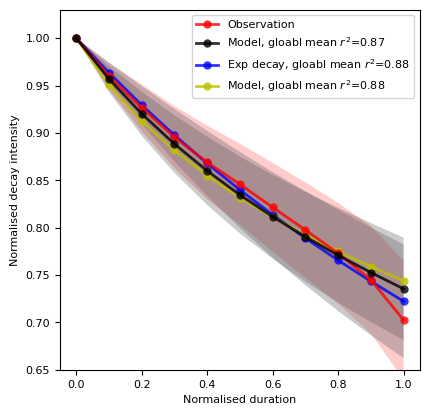

In [29]:
fig,ax=plt.subplots(1,1); fig.set_size_inches(4,4); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(100); 
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.35,hspace=0.3); fontsize = 8

norm_interp_vmax_in_inverse   = []
norm_interp_vmax_pred_inverse = []
norm_interp_vmax_pred_inverse_dis = []
for CCC in range(len(interp_vmax_in_inverse)):
    if dur_inverse[CCC]>=0:
        norm_interp_vmax_in_inverse  .append(interp_vmax_in_inverse          [CCC]/interp_vmax_in_inverse      [CCC][0])
        norm_interp_vmax_pred_inverse.append(interp_vmax_pred_inverse        [CCC]/interp_vmax_pred_inverse    [CCC][0])
        norm_interp_vmax_pred_inverse_dis.append(interp_vmax_pred_inverse_dis[CCC]/interp_vmax_pred_inverse_dis[CCC][0])
    
norm_interp_vmax_in_inverse       = np.asarray(norm_interp_vmax_in_inverse)
norm_interp_vmax_pred_inverse     = np.asarray(norm_interp_vmax_pred_inverse)
norm_interp_vmax_pred_inverse_dis = np.asarray(norm_interp_vmax_pred_inverse_dis)

NORM_OBS_INVERSE          = np.nanmean(norm_interp_vmax_in_inverse      ,0)
NORM_PRED_INVERSE         = np.nanmean(norm_interp_vmax_pred_inverse    ,0)
NORM_PRED_INVERSE_DIS     = np.nanmean(norm_interp_vmax_pred_inverse_dis,0)
NORM_OBS_INVERSE_STD      = np.nanstd (norm_interp_vmax_in_inverse      ,0) / np.sqrt(len(NORM_OBS_INVERSE)) 
NORM_PRED_INVERSE_STD     = np.nanstd (norm_interp_vmax_pred_inverse    ,0) / np.sqrt(len(NORM_OBS_INVERSE))
NORM_PRED_INVERSE_DIS_STD = np.nanstd (norm_interp_vmax_pred_inverse_dis,0) / np.sqrt(len(NORM_OBS_INVERSE))

norm_interp_vmax_in_exp   = []
norm_interp_vmax_pred_exp = []
for CCC in range(len(interp_vmax_in_exp)):
    if dur_exp[CCC]>=0:
        norm_interp_vmax_in_exp  .append(interp_vmax_in_exp          [CCC]/interp_vmax_in_exp      [CCC][0])
        norm_interp_vmax_pred_exp.append(interp_vmax_pred_exp        [CCC]/interp_vmax_pred_exp    [CCC][0])
    
norm_interp_vmax_in_exp       = np.asarray(norm_interp_vmax_in_exp)
norm_interp_vmax_pred_exp     = np.asarray(norm_interp_vmax_pred_exp)

NORM_OBS_EXP          = np.nanmean(norm_interp_vmax_in_exp      ,0)
NORM_PRED_EXP         = np.nanmean(norm_interp_vmax_pred_exp    ,0)
NORM_OBS_EXP_STD      = np.nanstd (norm_interp_vmax_in_exp      ,0) / np.sqrt(len(NORM_OBS_EXP)) 
NORM_PRED_EXP_STD     = np.nanstd (norm_interp_vmax_pred_exp    ,0) / np.sqrt(len(NORM_OBS_EXP))

norm_interp_vmax_in_latent   = []
norm_interp_vmax_pred_latent = []
for CCC in range(len(interp_vmax_in_latent)):
    if dur_latent[CCC]>=0:
        norm_interp_vmax_in_latent  .append(interp_vmax_in_latent          [CCC]/interp_vmax_in_latent      [CCC][0])
        norm_interp_vmax_pred_latent.append(interp_vmax_pred_latent        [CCC]/interp_vmax_pred_latent    [CCC][0])
    
norm_interp_vmax_in_latent       = np.asarray(norm_interp_vmax_in_latent)
norm_interp_vmax_pred_latent     = np.asarray(norm_interp_vmax_pred_latent)

NORM_OBS_LATENT          = np.nanmean(norm_interp_vmax_in_latent      ,0)
NORM_PRED_LATENT         = np.nanmean(norm_interp_vmax_pred_latent    ,0)
NORM_OBS_LATENT_STD      = np.nanstd (norm_interp_vmax_in_latent      ,0) / np.sqrt(len(NORM_OBS_LATENT)) 
NORM_PRED_LATENT_STD     = np.nanstd (norm_interp_vmax_pred_latent    ,0) / np.sqrt(len(NORM_OBS_LATENT))

_=ax.plot(np.linspace(0,1,11),NORM_OBS_INVERSE     ,'-o',color='r',lw=2,label='Observation'   ,zorder=11,alpha=.8,markeredgewidth=0,ms=6)
_=ax.plot(np.linspace(0,1,11),NORM_PRED_INVERSE    ,'-o',color='k' ,lw=2,label='Model, gloabl mean $r^2$=0.87'  ,zorder=12,alpha=.8,markeredgewidth=0,ms=6)
_=ax.fill_between(np.linspace(0,1,11),NORM_OBS_INVERSE-NORM_OBS_INVERSE_STD,NORM_OBS_INVERSE+NORM_OBS_INVERSE_STD,facecolor='r',edgecolor='none',alpha=.2,zorder=8)
_=ax.fill_between(np.linspace(0,1,11),NORM_PRED_INVERSE-NORM_PRED_INVERSE_STD,NORM_PRED_INVERSE+NORM_PRED_INVERSE_STD,facecolor='k' ,edgecolor='none',alpha=.2,zorder=9)

_=ax.plot(np.linspace(0,1,11),NORM_PRED_EXP    ,'-o',color='b' ,lw=2,label='Exp decay, gloabl mean $r^2$=0.88'  ,zorder=10,alpha=.8,markeredgewidth=0,ms=6)
_=ax.fill_between(np.linspace(0,1,11),NORM_PRED_EXP-NORM_PRED_EXP_STD,NORM_PRED_EXP+NORM_PRED_EXP_STD,facecolor='b' ,edgecolor='none',alpha=.2,zorder=9)

_=ax.plot(np.linspace(0,1,11),NORM_PRED_LATENT    ,'-o',color='y' ,lw=2,label='Model, gloabl mean $r^2$=0.88'  ,zorder=10,alpha=.8,markeredgewidth=0,ms=6)
_=ax.fill_between(np.linspace(0,1,11),NORM_PRED_EXP-NORM_PRED_EXP_STD,NORM_PRED_EXP+NORM_PRED_EXP_STD,facecolor='y' ,edgecolor='none',alpha=.2,zorder=9)

_=ax.tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.set_xlabel('Normalised duration',fontsize=fontsize)
_=ax.set_ylabel('Normalised decay intensity',fontsize=fontsize)
_=ax.legend(fontsize=fontsize)
_=ax.set_xlim([-0.05,1.05])
_=ax.set_ylim([0.65,1.03])
#------------------------

plt.savefig('/home/sw1013/www/FIGURES/Decay_Figure_1.png',dpi=600,bbox_inches='tight')
plt.savefig('/home/sw1013/www/FIGURES/Decay_Figure_1.pdf',dpi=600,bbox_inches='tight')

444890.46971364116

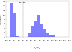

In [30]:
BV2_INVERSE,BV2_LATENT, CV_LATENT,r_LATENT = [],[],[],[]
for CCC in range(len(VMAX_PMIN_SERIES)):
#     if B_latent[CCC]<25e-7:
    if 1==1:
        r_LATENT   .extend([r_value_latent[CCC]])
        BV2_LATENT .extend([np.nanmean((VMAX_PMIN_SERIES[CCC][1][0]*.51444444)**2*B_latent[CCC] )])
        CV_LATENT  .extend([np.nanmean( VMAX_PMIN_SERIES[CCC][1][0]*.51444444    *C_latent[CCC] )])
        BV2_INVERSE.extend([np.nanmean((VMAX_PMIN_SERIES[CCC][1][0]*.51444444)**2*B_inverse[CCC])])
BV2_INVERSE,BV2_LATENT, CV_LATENT,r_LATENT = np.asarray(BV2_INVERSE),np.asarray(BV2_LATENT), np.asarray(CV_LATENT), np.asarray(r_LATENT)

fig,ax=plt.subplots(1,1); fig.set_size_inches(7,4); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(10); 
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.35,hspace=0.3); fontsize = 10

def plot_loghist(x, bins,ax):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    ax.hist(x, bins=logbins,color='b',alpha=.5)
    ax.set_xscale('log')

plot_loghist(BV2_LATENT/CV_LATENT, 20,ax)
np.nanmedian(BV2_LATENT/CV_LATENT)

# _=ax.plot([np.nanpercentile(BV2_LATENT/CV_LATENT,50),np.nanpercentile(BV2_LATENT/CV_LATENT,50)],[0,200],'-k')
_=ax.plot([1e3,1e3],[0,200],'--k')
_=ax.text(1e3*.9 ,158,'40%',fontsize=fontsize,ha='right',va='top',fontweight='bold')
_=ax.text(1e3*1.1,158,'60%',fontsize=fontsize,ha='left' ,va='top',fontweight='bold')

# _=ax.set_xscale('log')
_=ax.tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.set_xlim([1e-1,1e14])
_=ax.set_ylim([0,160])
_=ax.set_xticks(10.**np.arange(-1,15,1))
_=ax.set_xlabel('$κ{V_m}^2/α{V_m}$',fontsize=fontsize)
_=ax.set_ylabel('TC frequency',fontsize=fontsize)

plt.savefig('/home/sw1013/www/FIGURES/Decay_Figure_1.png',dpi=600,bbox_inches='tight')


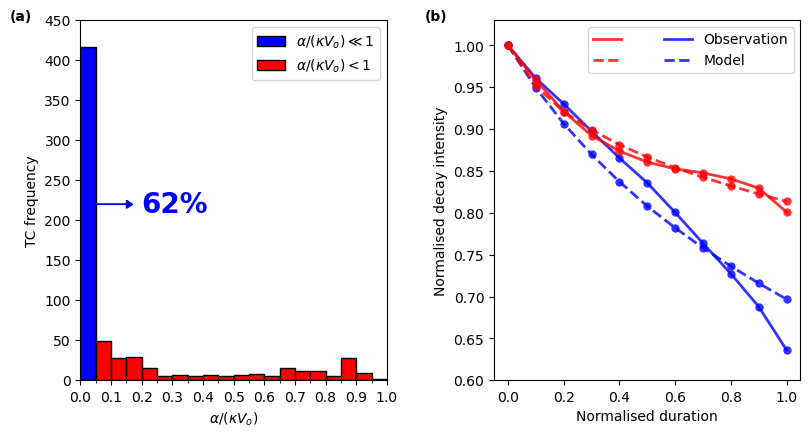

In [31]:
BV2_INVERSE,BV2_LATENT, CV_LATENT,r_LATENT = [],[],[],[]
for CCC in range(len(VMAX_PMIN_SERIES)):
#     if B_latent[CCC]<25e-7:
    if 1==1:
        r_LATENT   .extend([r_value_latent[CCC]])
        BV2_LATENT .extend([np.nanmean((VMAX_PMIN_SERIES[CCC][1][0]*.51444444)**2*B_latent[CCC] )])
        CV_LATENT  .extend([np.nanmean( VMAX_PMIN_SERIES[CCC][1][0]*.51444444    *C_latent[CCC] )])
        BV2_INVERSE.extend([np.nanmean((VMAX_PMIN_SERIES[CCC][1][0]*.51444444)**2*B_inverse[CCC])])
BV2_INVERSE,BV2_LATENT, CV_LATENT,r_LATENT = np.asarray(BV2_INVERSE),np.asarray(BV2_LATENT), np.asarray(CV_LATENT), np.asarray(r_LATENT)

fig,ax=plt.subplots(1,2); fig.set_size_inches(8,4); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(100); 
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.35,hspace=0.3); fontsize = 10

tmp = CV_LATENT/BV2_LATENT
_=ax[0].hist(tmp[tmp<=0.05], bins=np.linspace(0,1,21),align='mid', color='b', edgecolor='k',label='$α/(κ{V_o}){\ll}1$')
_=ax[0].hist(tmp[tmp> 0.05], bins=np.linspace(0,1,21),align='mid', color='r', edgecolor='k',label='$α/(κ{V_o})<1$')

_=ax[0].text(0.2 ,220,'62%',fontsize=fontsize+10,ha='left',va='center',fontweight='bold',color='b')
_=ax[0].arrow(0.05, 220, .1, 0, head_width=10, head_length=.02, fc='b', ec='b')

_=ax[0].set_xlim([0,1])
_=ax[0].set_ylim([0,450])
_=ax[0].set_xticks(np.arange(0,1.001,0.1))
_=ax[0].xaxis.set_minor_locator(plt.MultipleLocator(.05))
_=ax[0].set_xlabel('$α/(κ{V_o})$',fontsize=fontsize)
_=ax[0].set_ylabel('TC frequency',fontsize=fontsize)
_=ax[0].legend(fontsize=fontsize)
_=ax[0].text(-0.23,450,'(a)',fontsize=fontsize,fontweight='bold')

#=========================

norm_interp_vmax_in_inverse   = []
norm_interp_vmax_pred_inverse = []
norm_interp_vmax_pred_inverse_dis = []
for CCC in range(len(interp_vmax_in_inverse)):
    if dur_inverse[CCC]>=0:
        norm_interp_vmax_in_inverse  .append(interp_vmax_in_inverse          [CCC]/interp_vmax_in_inverse      [CCC][0])
        norm_interp_vmax_pred_inverse.append(interp_vmax_pred_inverse        [CCC]/interp_vmax_pred_inverse    [CCC][0])
        norm_interp_vmax_pred_inverse_dis.append(interp_vmax_pred_inverse_dis[CCC]/interp_vmax_pred_inverse_dis[CCC][0])
    
norm_interp_vmax_in_inverse       = np.asarray(norm_interp_vmax_in_inverse)
norm_interp_vmax_pred_inverse     = np.asarray(norm_interp_vmax_pred_inverse)
norm_interp_vmax_pred_inverse_dis = np.asarray(norm_interp_vmax_pred_inverse_dis)

NORM_OBS_INVERSE          = np.nanmean(norm_interp_vmax_in_inverse      ,0)
NORM_PRED_INVERSE         = np.nanmean(norm_interp_vmax_pred_inverse    ,0)
NORM_PRED_INVERSE_DIS     = np.nanmean(norm_interp_vmax_pred_inverse_dis,0)
NORM_OBS_INVERSE_STD      = np.nanstd (norm_interp_vmax_in_inverse      ,0) / np.sqrt(len(NORM_OBS_INVERSE)) 
NORM_PRED_INVERSE_STD     = np.nanstd (norm_interp_vmax_pred_inverse    ,0) / np.sqrt(len(NORM_OBS_INVERSE))
NORM_PRED_INVERSE_DIS_STD = np.nanstd (norm_interp_vmax_pred_inverse_dis,0) / np.sqrt(len(NORM_OBS_INVERSE))

norm_interp_vmax_in_exp   = []
norm_interp_vmax_pred_exp = []
for CCC in range(len(interp_vmax_in_exp)):
    if dur_exp[CCC]>=0:
        norm_interp_vmax_in_exp  .append(interp_vmax_in_exp          [CCC]/interp_vmax_in_exp      [CCC][0])
        norm_interp_vmax_pred_exp.append(interp_vmax_pred_exp        [CCC]/interp_vmax_pred_exp    [CCC][0])
    
norm_interp_vmax_in_exp       = np.asarray(norm_interp_vmax_in_exp)
norm_interp_vmax_pred_exp     = np.asarray(norm_interp_vmax_pred_exp)

NORM_OBS_EXP          = np.nanmean(norm_interp_vmax_in_exp      ,0)
NORM_PRED_EXP         = np.nanmean(norm_interp_vmax_pred_exp    ,0)
NORM_OBS_EXP_STD      = np.nanstd (norm_interp_vmax_in_exp      ,0) / np.sqrt(len(NORM_OBS_EXP)) 
NORM_PRED_EXP_STD     = np.nanstd (norm_interp_vmax_pred_exp    ,0) / np.sqrt(len(NORM_OBS_EXP))

norm_interp_vmax_in_latent         = []
norm_interp_vmax_pred_latent       = []
norm_interp_vmax_in_latent_left    = []
norm_interp_vmax_pred_latent_left  = []
norm_interp_vmax_in_latent_right   = []
norm_interp_vmax_pred_latent_right = []

for CCC in range(len(interp_vmax_in_latent)):
    if dur_latent[CCC]>=0:
        norm_interp_vmax_in_latent  .append(interp_vmax_in_latent          [CCC]/interp_vmax_in_latent      [CCC][0])
        norm_interp_vmax_pred_latent.append(interp_vmax_pred_latent        [CCC]/interp_vmax_pred_latent    [CCC][0])
        if BV2_LATENT[CCC]/CV_LATENT[CCC] <= 5e2:
            norm_interp_vmax_in_latent_left  .append(interp_vmax_in_latent          [CCC]/interp_vmax_in_latent      [CCC][0])
            norm_interp_vmax_pred_latent_left.append(interp_vmax_pred_latent        [CCC]/interp_vmax_pred_latent    [CCC][0])
        elif BV2_LATENT[CCC]/CV_LATENT[CCC] >= 5e2:
            norm_interp_vmax_in_latent_right  .append(interp_vmax_in_latent          [CCC]/interp_vmax_in_latent      [CCC][0])
            norm_interp_vmax_pred_latent_right.append(interp_vmax_pred_latent        [CCC]/interp_vmax_pred_latent    [CCC][0])
    
norm_interp_vmax_in_latent       = np.asarray(norm_interp_vmax_in_latent)
norm_interp_vmax_pred_latent     = np.asarray(norm_interp_vmax_pred_latent)
norm_interp_vmax_in_latent_left       = np.asarray(norm_interp_vmax_in_latent_left)
norm_interp_vmax_pred_latent_left     = np.asarray(norm_interp_vmax_pred_latent_left)
norm_interp_vmax_in_latent_right       = np.asarray(norm_interp_vmax_in_latent_right)
norm_interp_vmax_pred_latent_right     = np.asarray(norm_interp_vmax_pred_latent_right)

NORM_OBS_LATENT          = np.nanmean(norm_interp_vmax_in_latent      ,0)
NORM_PRED_LATENT         = np.nanmean(norm_interp_vmax_pred_latent    ,0)
NORM_OBS_LATENT_STD      = np.nanstd (norm_interp_vmax_in_latent      ,0) / np.sqrt(len(NORM_OBS_LATENT)) 
NORM_PRED_LATENT_STD     = np.nanstd (norm_interp_vmax_pred_latent    ,0) / np.sqrt(len(NORM_OBS_LATENT))
NORM_OBS_LATENT_LEFT          = np.nanmean(norm_interp_vmax_in_latent_left      ,0)
NORM_PRED_LATENT_LEFT         = np.nanmean(norm_interp_vmax_pred_latent_left    ,0)
NORM_OBS_LATENT_RIGHT          = np.nanmean(norm_interp_vmax_in_latent_right      ,0)
NORM_PRED_LATENT_RIGHT         = np.nanmean(norm_interp_vmax_pred_latent_right    ,0)

# _=ax.plot(np.linspace(0,1,11),NORM_OBS_LATENT     ,'-o',color='r',lw=2,label='Observation'   ,zorder=11,alpha=.8,markeredgewidth=0,ms=6)
# _=ax.plot(np.linspace(0,1,11),NORM_PRED_LATENT    ,'-o',color='k' ,lw=2,label='Model, gloabl mean $r^2$=0.87'  ,zorder=12,alpha=.8,markeredgewidth=0,ms=6)

_=ax[1].plot(np.linspace(0,1,11),NORM_OBS_LATENT_LEFT      ,'-o',color='r' ,lw=2,zorder=11,alpha=.8,markeredgewidth=0,ms=6)
_=ax[1].plot(np.linspace(0,1,11),NORM_PRED_LATENT_LEFT    ,'--o',color='r' ,lw=2,zorder=11,alpha=.8,markeredgewidth=0,ms=6)
_=ax[1].plot(np.linspace(0,1,11),NORM_OBS_LATENT_RIGHT     ,'-o',color='b' ,lw=2,zorder=10,alpha=.8,markeredgewidth=0,ms=6)
_=ax[1].plot(np.linspace(0,1,11),NORM_PRED_LATENT_RIGHT   ,'--o',color='b' ,lw=2,zorder=10,alpha=.8,markeredgewidth=0,ms=6)

_=ax[1].plot([-100,-90],[-100,-90] ,'-',color='r',lw=2,label=' '   ,zorder=11,alpha=.8,markeredgewidth=0,ms=6)
_=ax[1].plot([-100,-90],[-100,-90],'--',color='r' ,lw=2,label=' '  ,zorder=11,alpha=.8,markeredgewidth=0,ms=6)
_=ax[1].plot([-100,-90],[-100,-90] ,'-',color='b',lw=2,label='Observation'   ,zorder=10,alpha=.8,markeredgewidth=0,ms=6)
_=ax[1].plot([-100,-90],[-100,-90],'--',color='b' ,lw=2,label='Model'  ,zorder=10,alpha=.8,markeredgewidth=0,ms=6)

_=ax[1].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax[1].set_xlabel('Normalised duration',fontsize=fontsize)
_=ax[1].set_ylabel('Normalised decay intensity',fontsize=fontsize)
_=ax[1].set_xlim([-0.05,1.05])
_=ax[1].set_ylim([0.60,1.03])
_=ax[1].legend(fontsize=fontsize,ncol=2)
_=ax[1].text(-0.3,1.03,'(b)',fontsize=fontsize,fontweight='bold')

#------------------------

plt.savefig('/home/sw1013/www/FIGURES/Decay_Figure_1.png',dpi=600,bbox_inches='tight')


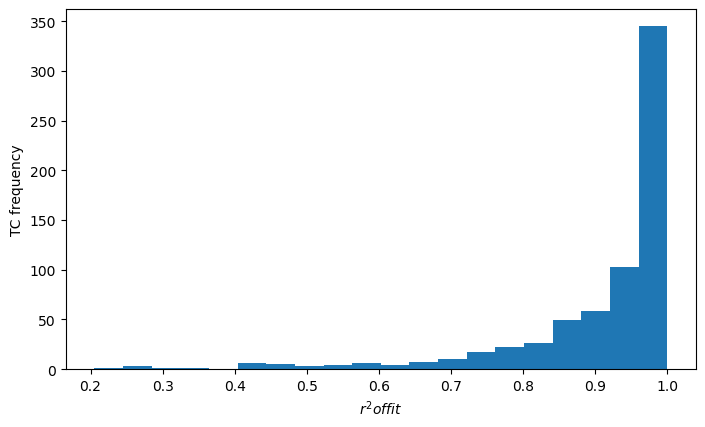

In [32]:
fig,ax=plt.subplots(1,1); fig.set_size_inches(7,4); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(100); 
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.35,hspace=0.3); fontsize = 10

_=ax.hist(r_value_latent,bins=20)

# _=ax.set_xscale('log')
_=ax.tick_params(axis='both', which='major', labelsize=fontsize)
# _=ax.set_xlim([1e-1,1e14])
# _=ax.set_ylim([0,160])
# _=ax.set_xticks(10.**np.arange(-1,15,1))
_=ax.set_xlabel('$r^2 of fit$',fontsize=fontsize)
_=ax.set_ylabel('TC frequency',fontsize=fontsize)

plt.savefig('/home/sw1013/www/FIGURES/Decay_Figure_1.png',dpi=600,bbox_inches='tight')


<hr>

## Correlation between decay factors and LI/LMI (FIGURE 3)

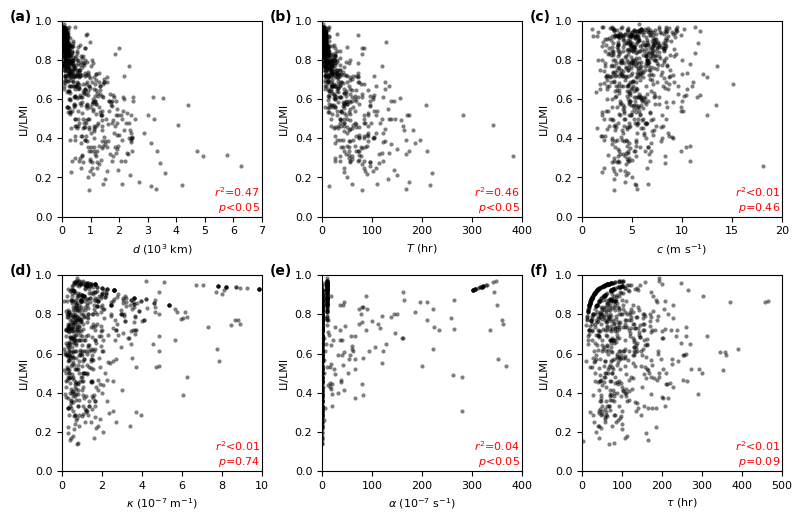

In [33]:
fig,ax=plt.subplots(2,3); fig.set_size_inches(8,5); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(100); 
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.3,hspace=0.3); fontsize = 8

interp_vmax_in_inverse = np.asarray(interp_vmax_in_inverse )
interp_vmax_pred_inverse = np.asarray(interp_vmax_pred_inverse)

dis_inverse = []
for CCC in range(len(VMAX_PMIN_SERIES)):
    dis_inverse.extend([VMAX_PMIN_SERIES[CCC][3]])
dis_inverse=np.asarray(dis_inverse)

# tmp_LMI and tmp_LF of individual cases with B_inverse case sequence
tmp_LILMI = []
for CCC in range(len(B_inverse)):
    tmp_LILMI.extend([interp_vmax_in_inverse[CCC][-1]/interp_vmax_in_inverse[CCC][ 0]])
tmp_LILMI=np.asarray(tmp_LILMI)
#
_=ax.flatten()[0].plot(trajectory_inverse/1e3,tmp_LILMI,'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[0].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[0].set_ylabel('LI/LMI',fontsize=fontsize)
_=ax.flatten()[0].set_xlabel('$d$ (10$^3$ km)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_LILMI,trajectory_inverse)
p_str = str(np.round(p,2))
if p<0.05:
    p_str = '<0.05'
_=ax.flatten()[0].text(7*.99,1*.01,'$r^2$='+str('%.2f' %np.round(r**2,2))+'\n$p$'+p_str,fontsize=fontsize,va='bottom',ha='right',color='r')
_=ax.flatten()[0].text(-1.82,1,'(a)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[0].set_ylim([0,1])
_=ax.flatten()[0].set_xlim([0,7])
_=ax.flatten()[0].set_xticks(np.arange(0,8,1))
#
_=ax.flatten()[1].plot(dur_inverse,tmp_LILMI,'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[1].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[1].set_ylabel('LI/LMI',fontsize=fontsize)
_=ax.flatten()[1].set_xlabel('$T$ (hr)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_LILMI,dur_inverse)
p_str = str(np.round(p,2))
if p<0.05:
    p_str = '<0.05'
_=ax.flatten()[1].text(400*.99,1*.01,'$r^2$='+str('%.2f' %np.round(r**2,2))+'\n$p$'+p_str,fontsize=fontsize,va='bottom',ha='right',color='r')
_=ax.flatten()[1].text(-104,1,'(b)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[1].set_ylim([0,1])
_=ax.flatten()[1].set_xlim([0,400])
_=ax.flatten()[1].set_xticks(np.arange(0,401,100))
#
tmp = trajectory_inverse*1e3/(dur_inverse*3600)
_=ax.flatten()[2].plot(tmp,tmp_LILMI,'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[2].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[2].set_ylabel('LI/LMI',fontsize=fontsize)
_=ax.flatten()[2].set_xlabel('$c$ (m s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_LILMI,tmp)
p_str = '='+str('%.2f' %np.round(p,2))
if p<0.05:
    p_str = '<0.05'
r_str = '='+str('%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str='<0.01'
_=ax.flatten()[2].text(20*.99,1*.01,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='bottom',ha='right',color='r')
_=ax.flatten()[2].text(-5.2,1,'(c)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[2].set_ylim([0,1])
_=ax.flatten()[2].set_xlim([0,20])
_=ax.flatten()[2].set_xticks(np.arange(0,21,5))
#
DUR_AT_LEAST_POINTS = 0
#
Ref_B = 1.0e-7
B_latent=np.asarray(B_latent)
_=ax.flatten()[3].plot(B_latent[dur_inverse>=DUR_AT_LEAST_POINTS]/Ref_B,tmp_LILMI[dur_inverse>=DUR_AT_LEAST_POINTS],'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[3].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[3].set_ylabel('LI/LMI',fontsize=fontsize)
_=ax.flatten()[3].set_xlabel('$κ$ (10$^{-7}$ m$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_LILMI[(~np.isnan(B_latent))&(dur_inverse>=DUR_AT_LEAST_POINTS)],B_latent[(~np.isnan(B_latent))&(dur_inverse>=DUR_AT_LEAST_POINTS)])
p_str = '='+str('%.2f' %np.round(p,2))
if p<0.05:
    p_str = '<0.05'
r_str = '='+str('%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str='<0.01'
_=ax.flatten()[3].text(10*.99,1*.01,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='bottom',ha='right',color='r')
_=ax.flatten()[3].text(-2.6,1,'(d)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[3].set_ylim([0,1])
_=ax.flatten()[3].set_xlim([0,10])
_=ax.flatten()[3].set_xticks(np.arange(0,11,2))
#
Ref_B = 1.0e-7
C_latent=np.asarray(C_latent)
_=ax.flatten()[4].plot(C_latent[dur_inverse>=DUR_AT_LEAST_POINTS]/Ref_B,tmp_LILMI[dur_inverse>=DUR_AT_LEAST_POINTS],'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[4].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[4].set_ylabel('LI/LMI',fontsize=fontsize)
_=ax.flatten()[4].set_xlabel('$α$ (10$^{-7}$ s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_LILMI[(~np.isnan(B_latent))&(dur_inverse>=DUR_AT_LEAST_POINTS)],C_latent[(~np.isnan(B_latent))&(dur_inverse>=DUR_AT_LEAST_POINTS)])
p_str = '='+str('%.2f' %np.round(p,2))
if p<0.05:
    p_str = '<0.05'
r_str = '='+str('%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str='<0.01'
_=ax.flatten()[4].text(400*.99,1*.01,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='bottom',ha='right',color='r')
_=ax.flatten()[4].text(-104,1,'(e)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[4].set_ylim([0,1])
_=ax.flatten()[4].set_xlim([0,400])
_=ax.flatten()[4].set_xticks(np.arange(0,401,100))
#
dur_exp = np.asarray(dur_exp)
B_exp=np.asarray(B_exp)
_=ax.flatten()[5].plot(1/(B_exp[dur_exp>=DUR_AT_LEAST_POINTS]),tmp_LILMI[dur_exp>=DUR_AT_LEAST_POINTS],'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[5].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[5].set_ylabel('LI/LMI',fontsize=fontsize)
_=ax.flatten()[5].set_xlabel('$τ$ (hr)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_LILMI[(~np.isnan(B_exp))&(dur_exp>=DUR_AT_LEAST_POINTS)],B_exp[(~np.isnan(B_exp))&(dur_exp>=DUR_AT_LEAST_POINTS)])
p_str = '='+str('%.2f' %np.round(p,2))
if p<0.05:
    p_str = '<0.05'
r_str = '='+str('%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str='<0.01'
_=ax.flatten()[5].text(500*.99,1*.01,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='bottom',ha='right',color='r')
_=ax.flatten()[5].text(-130,1,'(f)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[5].set_ylim([0,1])
_=ax.flatten()[5].set_xlim([0,500])
_=ax.flatten()[5].set_xticks(np.arange(0,501,100))
#
plt.savefig('/home/sw1013/www/FIGURES/Decay_Figure_2.png',dpi=600,bbox_inches='tight')
plt.savefig('/home/sw1013/www/FIGURES/Decay_Figure_2.pdf',dpi=600,bbox_inches='tight')

**Basin breakdown - std**

In [34]:
def basin_mean_std (AREA):
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([VMAX_PMIN_SERIES[CCC][1][0]*.514444])
    output1 = str(round(np.nanmean(tmp)).astype(int))+'±'+str(round(np.nanstd(tmp)).astype(int))+'('+str(round(np.nanstd(tmp)/np.nanmean(tmp)*100).astype(int))+'%)'
    
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([VMAX_PMIN_SERIES[CCC][1][-1]*.514444])
    output2 = str(round(np.nanmean(tmp)).astype(int))+'±'+str(round(np.nanstd(tmp)).astype(int))+'('+str(round(np.nanstd(tmp)/np.nanmean(tmp)*100).astype(int))+'%)'
    
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([dur_inverse[CCC]])
    output3 = str(round(np.nanmean(tmp)).astype(int))+'±'+str(round(np.nanstd(tmp)).astype(int))+'('+str(round(np.nanstd(tmp)/np.nanmean(tmp)*100).astype(int))+'%)'
    
    Ref_B = 1.0e-7
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([B_inverse_dis[CCC]/Ref_B])
    output4 = str(round(np.nanmean(tmp),1))+'±'+str(round(np.nanstd(tmp),1))+'('+str(round(np.nanstd(tmp)/np.nanmean(tmp)*100).astype(int))+'%)'
    
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([B_inverse[CCC]*dur_inverse[CCC]*3600*1000])
    output5 = str(round(np.nanmean(tmp),1))+'±'+str(round(np.nanstd(tmp),1))+'('+str(round(np.nanstd(tmp)/np.nanmean(tmp)*100).astype(int))+'%)'
    
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([1/(VMAX_PMIN_SERIES[CCC][1][0]*.514444)*1000])
    output6 = str(round(np.nanmean(tmp),1))+'±'+str(round(np.nanstd(tmp),1))+'('+str(round(np.nanstd(tmp)/np.nanmean(tmp)*100).astype(int))+'%)'
    
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([trajectory_inverse[CCC]])
    output7 = str(int(round(np.nanmean(tmp))))+'±'+str(int(round(np.nanstd(tmp))))+'('+str(round(np.nanstd(tmp)/np.nanmean(tmp)*100).astype(int))+'%)'
    
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([speed_inverse[CCC]])
    output8 = str(round(np.nanmean(tmp),1))+'±'+str(round(np.nanstd(tmp),1))+'('+str(round(np.nanstd(tmp)/np.nanmean(tmp)*100).astype(int))+'%)'
    
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([B_exp[CCC]])
    output9 = str(round(np.nanmean(tmp),1))+'±'+str(round(np.nanstd(tmp),1))+'('+str(round(np.nanstd(tmp)/np.nanmean(tmp)*100).astype(int))+'%)'
    
    return output1, output2,output3,output4,output5,output6,output7,output8,output9


In [35]:
TABLE = pd.DataFrame(index=['LMI','LI','$\Delta$t','$\kappa$','$\Delta$t${\times}\kappa$','1/LMI','$\Delta$d','c','α'],columns=['Global','NH','SH','WP','EP','NA','NI','SI','SP'])
for BBB,AREA in enumerate( [
    ['WP','EP','NA','NI','SI','SP'],
    ['WP','EP','NA','NI'],
    ['SI','SP'],
    ['WP'],
    ['EP'],
    ['NA'],
    ['NI'],
    ['SI'],
    ['SP'],
            ]):
    output1,output2,output3,output4,output5,output6,output7,output8,output9 = basin_mean_std(AREA)
    TABLE.iloc[0,BBB] = output1
    TABLE.iloc[1,BBB] = output2
    TABLE.iloc[2,BBB] = output3
    TABLE.iloc[3,BBB] = output4
    TABLE.iloc[4,BBB] = output5
    TABLE.iloc[5,BBB] = output6
    TABLE.iloc[6,BBB] = output7
    TABLE.iloc[7,BBB] = output8
    TABLE.iloc[8,BBB] = output9
TABLE
#TABLE.to_clipboard() 

,Global,NH,SH,WP,EP,NA,NI,SI,SP
LMI,54±14(26%),54±14(26%),53±13(25%),55±14(25%),53±12(24%),53±15(29%),51±14(27%),52±13(25%),55±13(23%)
LI,37±13(36%),37±13(36%),39±13(35%),37±13(35%),31±12(39%),39±15(37%),37±15(40%),39±13(34%),38±14(37%)
$\Delta$t,37±46(125%),38±45(117%),32±52(162%),39±43(110%),46±49(106%),38±54(142%),23±28(123%),31±55(176%),35±44(126%)
$\kappa$,1.4±1.3(95%),1.3±1.3(98%),1.7±1.4(81%),1.1±1.2(101%),1.6±1.5(93%),1.6±1.5(94%),2.0±1.5(72%),1.8±1.4(79%),1.4±1.3(87%)
$\Delta$t${\times}\kappa$,9.2±10.8(118%),9.3±10.1(109%),8.7±13.6(157%),8.5±8.3(98%),13.4±13.6(101%),9.0±11.0(122%),10.1±13.4(133%),8.7±15.2(174%),8.5±8.1(96%)
1/LMI,19.9±5.4(27%),19.8±5.4(27%),20.2±5.5(27%),19.4±5.3(27%),20.0±4.8(24%),20.6±5.8(28%),21.0±5.6(27%),20.5±5.7(28%),19.4±4.9(25%)
$\Delta$d,687±836(122%),739±864(117%),446±635(142%),767±770(100%),763±879(115%),827±1245(151%),334±362(108%),410±632(154%),537±632(118%)
c,5.7±3.2(55%),5.9±3.3(55%),4.6±2.0(44%),6.0±2.1(36%),5.2±2.1(40%),6.6±6.4(98%),5.0±2.4(47%),4.4±1.7(40%),5.2±2.5(49%)
α,0.0±0.0(105%),0.0±0.0(112%),0.0±0.0(71%),0.0±0.0(83%),0.0±0.0(74%),0.0±0.0(163%),0.0±0.0(71%),0.0±0.0(72%),0.0±0.0(70%)


**Basin breakdown - Q3-Q1 / Q3+Q1**

In [36]:
def basin_mean_std (AREA):
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([VMAX_PMIN_SERIES[CCC][1][0]*.514444])
    output1 = str(round(np.nanmedian(tmp)).astype(int))+'('+str(round((np.nanquantile(tmp,.75)-np.nanquantile(tmp,.25)) / (np.nanquantile(tmp,.75)+np.nanquantile(tmp,.25)) * 100).astype(int))+')'
    
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([VMAX_PMIN_SERIES[CCC][1][-1]*.514444])
    output2 = str(round(np.nanmedian(tmp)).astype(int))+'('+str(round((np.nanquantile(tmp,.75)-np.nanquantile(tmp,.25)) / (np.nanquantile(tmp,.75)+np.nanquantile(tmp,.25)) * 100).astype(int))+')'
    
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([dur_inverse[CCC]])
    output3 = str(round(np.nanmedian(tmp)).astype(int))+'('+str(round((np.nanquantile(tmp,.75)-np.nanquantile(tmp,.25)) / (np.nanquantile(tmp,.75)+np.nanquantile(tmp,.25)) * 100).astype(int))+')'
    
    Ref_B = 1.0e-7
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([B_inverse_dis[CCC]/Ref_B*10])
    output4 = str(round(np.nanmedian(tmp)).astype(int))+'('+str(round((np.nanquantile(tmp,.75)-np.nanquantile(tmp,.25)) / (np.nanquantile(tmp,.75)+np.nanquantile(tmp,.25)) * 100).astype(int))+')'
    
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([B_inverse[CCC]*dur_inverse[CCC]*3600*1000])
    output5 = str(round(np.nanmedian(tmp)).astype(int))+'('+str(round((np.nanquantile(tmp,.75)-np.nanquantile(tmp,.25)) / (np.nanquantile(tmp,.75)+np.nanquantile(tmp,.25)) * 100).astype(int))+')'
    
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([1/(VMAX_PMIN_SERIES[CCC][1][0]*.514444)*1000])
    output6 = str(round(np.nanmedian(tmp)).astype(int))+'('+str(round((np.nanquantile(tmp,.75)-np.nanquantile(tmp,.25)) / (np.nanquantile(tmp,.75)+np.nanquantile(tmp,.25)) * 100).astype(int))+')'
    
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([trajectory_inverse[CCC]])
    output7 = str(round(np.nanmedian(tmp)).astype(int))+'('+str(round((np.nanquantile(tmp,.75)-np.nanquantile(tmp,.25)) / (np.nanquantile(tmp,.75)+np.nanquantile(tmp,.25)) * 100).astype(int))+')'
    
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([speed_inverse[CCC]])
    output8 = str(round(np.nanmedian(tmp)).astype(int))+'('+str(round((np.nanquantile(tmp,.75)-np.nanquantile(tmp,.25)) / (np.nanquantile(tmp,.75)+np.nanquantile(tmp,.25)) * 100).astype(int))+')'
    
    return output1, output2,output3,output4,output5,output6,output7,output8


In [37]:
TABLE = pd.DataFrame(index=['LMI','LI','$\Delta$t','$\kappa$','$\Delta$t${\times}\kappa$','1/LMI','$\Delta$d','c'],columns=['Global','NH','SH','WP','EP','NA','NI','SI','SP'])
for BBB,AREA in enumerate( [
    ['WP','EP','NA','NI','SI','SP'],
    ['WP','EP','NA','NI'],
    ['SI','SP'],
    ['WP'],
    ['EP'],
    ['NA'],
    ['NI'],
    ['SI'],
    ['SP'],
            ]):
    output1,output2,output3,output4,output5,output6,output7,output8 = basin_mean_std(AREA)
    TABLE.iloc[0,BBB] = output1
    TABLE.iloc[1,BBB] = output2
    TABLE.iloc[2,BBB] = output3
    TABLE.iloc[3,BBB] = output4
    TABLE.iloc[4,BBB] = output5
    TABLE.iloc[5,BBB] = output6
    TABLE.iloc[6,BBB] = output7
    TABLE.iloc[7,BBB] = output8
TABLE[['Global','WP','EP','NA','NI','SI','SP']].reindex(['LI','LMI','1/LMI','$\Delta$t${\times}\kappa$','$\Delta$d','$\Delta$t','$\kappa$','c'])
#TABLE.to_clipboard() 

,Global,WP,EP,NA,NI,SI,SP
LI,36(24),36(24),32(28),39(21),34(24),40(23),34(25)
LMI,54(22),54(23),54(17),51(25),49(25),57(25),54(16)
1/LMI,19(22),19(23),19(17),19(25),21(25),18(25),19(16)
$\Delta$t${\times}\kappa$,5(62),6(60),8(69),5(61),4(59),4(45),6(79)
$\Delta$d,349(80),502(77),391(74),269(86),217(67),194(75),313(79)
$\Delta$t,18(80),22(81),26(79),15(90),10(82),12(71),18(76)
$\kappa$,9(57),7(53),10(49),11(67),17(52),14(56),10(40)
c,5(27),6(22),5(31),6(32),5(28),4(28),5(22)


**Basin breakdown - median absolute deviation / median**

In [38]:
def basin_mean_std (AREA):
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([VMAX_PMIN_SERIES[CCC][1][0]*.514444])
    output1 = str(round(np.nanmedian(tmp)).astype(int))+'('+str(round((scipy.stats.median_absolute_deviation(tmp)) / (np.nanmean(tmp)) * 100).astype(int))+')'
    
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([VMAX_PMIN_SERIES[CCC][1][-1]*.514444])
    output2 = str(round(np.nanmedian(tmp)).astype(int))+'('+str(round((scipy.stats.median_absolute_deviation(tmp)) / (np.nanmean(tmp)) * 100).astype(int))+')'
    
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([dur_inverse[CCC]])
    output3 = str(round(np.nanmedian(tmp)).astype(int))+'('+str(round((scipy.stats.median_absolute_deviation(tmp)) / (np.nanmean(tmp)) * 100).astype(int))+')'
    
    Ref_B = 1.0e-7
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([B_inverse_dis[CCC]/Ref_B*10])
    output4 = str(round(np.nanmedian(tmp)).astype(int))+'('+str(round((scipy.stats.median_absolute_deviation(tmp)) / (np.nanmean(tmp)) * 100).astype(int))+')'
    
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([B_inverse[CCC]*dur_inverse[CCC]*3600*1000])
    output5 = str(round(np.nanmedian(tmp)).astype(int))+'('+str(round((scipy.stats.median_absolute_deviation(tmp)) / (np.nanmean(tmp)) * 100).astype(int))+')'
    
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([1/(VMAX_PMIN_SERIES[CCC][1][0]*.514444)*1000])
    output6 = str(round(np.nanmedian(tmp)).astype(int))+'('+str(round((scipy.stats.median_absolute_deviation(tmp)) / (np.nanmean(tmp)) * 100).astype(int))+')'
    
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([trajectory_inverse[CCC]])
    output7 = str(round(np.nanmedian(tmp)).astype(int))+'('+str(round((scipy.stats.median_absolute_deviation(tmp)) / (np.nanmean(tmp)) * 100).astype(int))+')'
    
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][7] in AREA):
                tmp.extend([speed_inverse[CCC]])
    output8 = str(round(np.nanmedian(tmp)).astype(int))+'('+str(round((scipy.stats.median_absolute_deviation(tmp)) / (np.nanmean(tmp)) * 100).astype(int))+')'
    
    return output1, output2,output3,output4,output5,output6,output7,output8


In [39]:
TABLE = pd.DataFrame(index=['LMI','LI','$\Delta$t','$\kappa$','$\Delta$t${\times}\kappa$','1/LMI','$\Delta$d','c'],columns=['Global','NH','SH','WP','EP','NA','NI','SI','SP'])
for BBB,AREA in enumerate( [
    ['WP','EP','NA','NI','SI','SP'],
    ['WP','EP','NA','NI'],
    ['SI','SP'],
    ['WP'],
    ['EP'],
    ['NA'],
    ['NI'],
    ['SI'],
    ['SP'],
            ]):
    output1,output2,output3,output4,output5,output6,output7,output8 = basin_mean_std(AREA)
    TABLE.iloc[0,BBB] = output1
    TABLE.iloc[1,BBB] = output2
    TABLE.iloc[2,BBB] = output3
    TABLE.iloc[3,BBB] = output4
    TABLE.iloc[4,BBB] = output5
    TABLE.iloc[5,BBB] = output6
    TABLE.iloc[6,BBB] = output7
    TABLE.iloc[7,BBB] = output8
TABLE[['Global','WP','EP','NA','NI','SI','SP']].reindex(['LI','LMI','1/LMI','$\Delta$t${\times}\kappa$','$\Delta$d','$\Delta$t','$\kappa$','c'])
#TABLE.to_clipboard() 

,Global,WP,EP,NA,NI,SI,SP
LI,36(37),36(31),32(44),39(33),34(49),40(33),34(36)
LMI,54(35),54(35),54(25),51(36),49(37),57(29),54(28)
1/LMI,19(31),19(27),19(22),19(36),21(37),18(20),19(24)
$\Delta$t${\times}\kappa$,5(52),6(59),8(57),5(50),4(36),4(26),6(77)
$\Delta$d,349(60),502(77),391(56),269(37),217(66),194(50),313(66)
$\Delta$t,18(60),22(62),26(63),15(47),10(48),12(43),18(63)
$\kappa$,9(53),7(45),10(38),11(70),17(68),14(66),10(46)
c,5(38),6(32),5(44),6(35),5(39),4(37),5(35)


**Major TC percentile**

In [40]:
Ref_B = 1e-7

LI_inverse = []
for CCC in range(len(VMAX_PMIN_SERIES)):
    LI_inverse.extend([VMAX_PMIN_SERIES[CCC][1][-1]*.514444])
LI_inverse = np.asarray(LI_inverse)
A_inverse = np.asarray(A_inverse)

def find_var_percentile (x,AREA):
    x = np.asarray(x)
    
    tmp_AREA = []
    for CCC in range(len(VMAX_PMIN_SERIES)):
        if (VMAX_PMIN_SERIES[CCC][7] in AREA):
            tmp_AREA.extend([True])
        else:
            tmp_AREA.extend([False])
    
    tmp_TOP_LI = LI_inverse>=96*.514444 # np.percentile(LI_inverse[tmp_AREA],90)
    
    return str(round(np.nanmedian(x[tmp_TOP_LI & tmp_AREA])).astype(int)) +'('+str(round(scipy.stats.percentileofscore(x[tmp_AREA],np.nanmedian(x[tmp_TOP_LI & tmp_AREA]))))+')'
    
TABLE = pd.DataFrame(index=['LI','LMI','1/LMI','$\Delta$t${\times}\kappa$','$\Delta$d','$\Delta$t','$\kappa$','c','τ','α'],columns=['Global','NH','SH','WP','EP','NA','NI','SI','SP'])
for BBB,AREA in enumerate( [
    ['WP','EP','NA','NI','SI','SP'],
    ['WP','EP','NA','NI'],
    ['SI','SP'],
    ['WP'],
    ['EP'],
    ['NA'],
    ['NI'],
    ['SI'],
    ['SP'],
            ]):
    dur_inverse = np.asarray(dur_inverse)
    TABLE.iloc[0,BBB] = find_var_percentile(LI_inverse                       ,AREA)
    TABLE.iloc[1,BBB] = find_var_percentile(A_inverse                        ,AREA)
    TABLE.iloc[2,BBB] = find_var_percentile(1/A_inverse                 *1000,AREA)
    TABLE.iloc[3,BBB] = find_var_percentile(dur_inverse*3600*B_inverse  *1000,AREA)
    TABLE.iloc[4,BBB] = find_var_percentile(trajectory_inverse               ,AREA)
    TABLE.iloc[5,BBB] = find_var_percentile(dur_inverse                      ,AREA)
    TABLE.iloc[6,BBB] = find_var_percentile(B_latent                /Ref_B*10,AREA)
    TABLE.iloc[7,BBB] = find_var_percentile(speed_inverse                    ,AREA) 
    TABLE.iloc[8,BBB] = find_var_percentile(1/B_exp                          ,AREA) 
    TABLE.iloc[9,BBB] = find_var_percentile(C_latent                /Ref_B   ,AREA) 

TABLE[['Global','WP','EP','NA','NI','SI','SP']]

,Global,WP,EP,NA,NI,SI,SP
LI,57(92),58(93),53(97),59(91),55(90),55(89),59(92)
LMI,67(79),69(80),68(92),68(80),69(88),66(81),64(74)
1/LMI,15(22),14(20),15(8),15(21),14(15),15(19),16(29)
$\Delta$t${\times}\kappa$,2(18),2(15),3(19),2(24),2(27),3(26),1(23)
$\Delta$d,172(34),186(30),332(42),188(47),69(25),160(45),92(30)
$\Delta$t,9(35),9(30),12(35),9(43),6(35),9(44),6(33)
$\kappa$,8(33),6(31),9(36),10(29),10(27),9(33),8(36)
c,6(58),6(59),7(75),7(73),4(46),4(51),7(82)
τ,74(50),82(52),72(50),73(53),73(67),66(52),58(45)
α,0(56),0(53),5(64),10(56),10(65),0(44),0(61)


In [41]:
Ref_B = 1e-7

LI_inverse = []
for CCC in range(len(VMAX_PMIN_SERIES)):
    LI_inverse.extend([VMAX_PMIN_SERIES[CCC][1][-1]*.514444])
LI_inverse = np.asarray(LI_inverse)
A_inverse = np.asarray(A_inverse)

tmp_mask = LI_inverse>=96*.514444

def find_std_percentile (X):
    X = np.asarray(X)
    
    tmp = X[tmp_mask]
    
    tmp_resample = []
    for LLL in range(10000):
        resample=np.random.choice(tmp,size=tmp.shape,replace=True)
        resample = scipy.stats.percentileofscore(X,np.nanmedian(resample))
        tmp_resample.append(np.nanmedian(resample))
        
    return str(np.round(np.nanstd(tmp_resample)).astype('int'),)

tmp = find_std_percentile(A_inverse)

tmp

    
TABLE = pd.DataFrame(index=['LI','LMI','1/LMI','$\Delta$t${\times}\kappa$','$\Delta$d','$\Delta$t','$\kappa$','c','τ','α'],columns=['Global','NH','SH','WP','EP','NA','NI','SI','SP'])
for BBB,AREA in enumerate( [
    ['WP','EP','NA','NI','SI','SP'],
# #     ['WP','EP','NA','NI'],
# #     ['SI','SP'],
# #     ['WP'],
# #     ['EP'],
# #     ['NA'],
# #     ['NI'],
# #     ['SI'],
# #     ['SP'],
            ]):
    dur_inverse = np.asarray(dur_inverse)
    TABLE.iloc[0,BBB] = find_std_percentile(LI_inverse                       )
    TABLE.iloc[1,BBB] = find_std_percentile(A_inverse                        )
    TABLE.iloc[2,BBB] = find_std_percentile(1/A_inverse                 *1000)
    TABLE.iloc[3,BBB] = find_std_percentile(dur_inverse*3600*B_inverse  *1000)
    TABLE.iloc[4,BBB] = find_std_percentile(trajectory_inverse               )
    TABLE.iloc[5,BBB] = find_std_percentile(dur_inverse                      )
    TABLE.iloc[6,BBB] = find_std_percentile(B_latent                /Ref_B*10)
    TABLE.iloc[7,BBB] = find_std_percentile(speed_inverse                    ) 
    TABLE.iloc[8,BBB] = find_std_percentile(1/B_exp                          ) 
    TABLE.iloc[9,BBB] = find_std_percentile(C_latent                /Ref_B   ) 

TABLE[['Global','WP','EP','NA','NI','SI','SP']]

'3'

,Global,WP,EP,NA,NI,SI,SP
LI,1,NaN,NaN,NaN,NaN,NaN,NaN
LMI,3,NaN,NaN,NaN,NaN,NaN,NaN
1/LMI,3,NaN,NaN,NaN,NaN,NaN,NaN
$\Delta$t${\times}\kappa$,2,NaN,NaN,NaN,NaN,NaN,NaN
$\Delta$d,4,NaN,NaN,NaN,NaN,NaN,NaN
$\Delta$t,3,NaN,NaN,NaN,NaN,NaN,NaN
$\kappa$,4,NaN,NaN,NaN,NaN,NaN,NaN
c,5,NaN,NaN,NaN,NaN,NaN,NaN
τ,5,NaN,NaN,NaN,NaN,NaN,NaN
α,6,NaN,NaN,NaN,NaN,NaN,NaN


**Total landfall TCs, LMI, LI, t (>0 ie LMI not LI time), κ distribution**

53.98169955290612 13.95765048129045
37.234705371087934 13.487188440730174
37.30104321907601 46.44300369330406
2.1597784639057545 2.8256789708612717
30.76308644340947 79.30111329985799
91.76702880687738 66.58777401377688


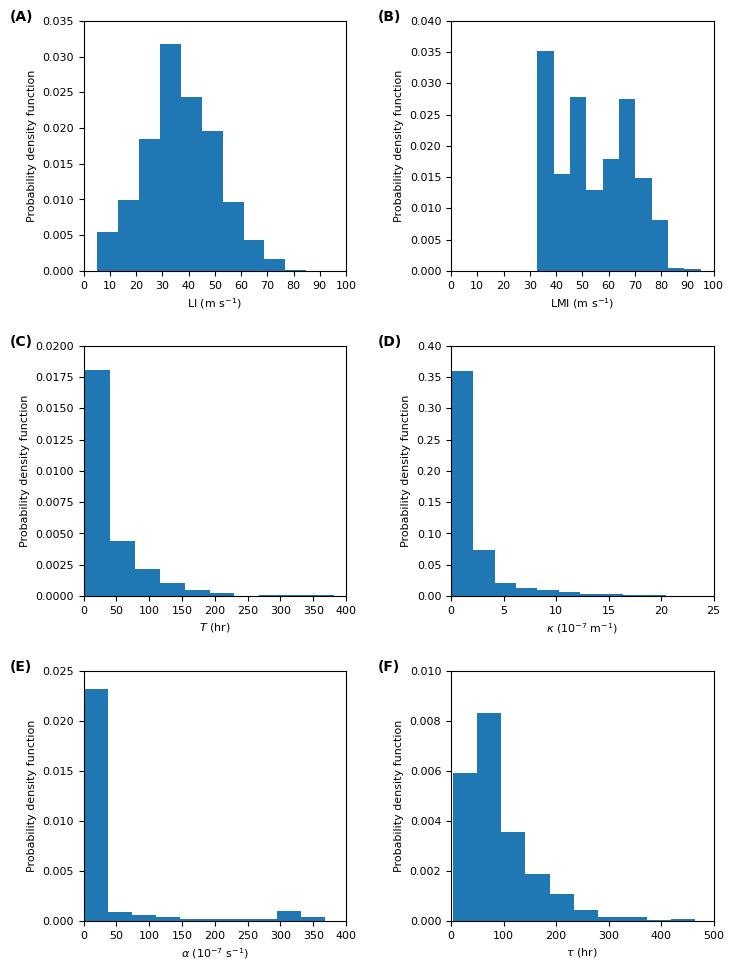

In [42]:
fig,ax=plt.subplots(3,2); fig.set_size_inches(7,10); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(100); 
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.4,hspace=0.3); fontsize = 8

A_inverse = np.asarray(A_inverse)
X= A_inverse[dur_inverse>0]
_=ax[0][1].hist(X,density=True,bins=10)
_=ax[0][1].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax[0][1].set_xticks(np.arange(0,101,10))
_=ax[0][1].set_xlabel('LMI (m s$^{-1}$)',fontsize=fontsize)
_=ax[0][1].set_ylabel('Probability density function',fontsize=fontsize)
_=ax[0][1].set_ylim(0,0.04)
_=ax[0][1].set_xlim(0,100)
_=ax[0][1].text(-28,0.04,'(B)',fontsize=fontsize+2,fontweight='bold')
print(np.nanmean(X),np.nanstd(X))

X=LI_inverse[dur_inverse>-1]
_=ax[0][0].hist(X,density=True,bins=10)
_=ax[0][0].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax[0][0].set_xticks(np.arange(0,101,10))
_=ax[0][0].set_xlabel('LI (m s$^{-1}$)',fontsize=fontsize)
_=ax[0][0].set_ylabel('Probability density function',fontsize=fontsize)
_=ax[0][0].set_ylim(0,0.035)
_=ax[0][0].set_xlim(0,100)
_=ax[0][0].text(-28,0.035,'(A)',fontsize=fontsize+2,fontweight='bold')
print(np.nanmean(X),np.nanstd(X))

X=dur_inverse[dur_inverse>-1]
_=ax[1][0].hist(X,density=True,bins=10)
_=ax[1][0].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax[1][0].set_xticks(np.arange(0,401,50))
_=ax[1][0].set_xlabel('$T$ (hr)',fontsize=fontsize)
_=ax[1][0].set_ylabel('Probability density function',fontsize=fontsize)
_=ax[1][0].set_ylim(0,0.02)
_=ax[1][0].set_xlim(0,400)
_=ax[1][0].text(-112,0.02,'(C)',fontsize=fontsize+2,fontweight='bold')
print(np.nanmean(X),np.nanstd(X))

X=B_latent[(dur_inverse>-1)&(B_latent<25e-7)]/Ref_B
_=ax[1][1].hist(X,density=True,bins=10)
_=ax[1][1].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax[1][1].set_xticks(np.arange(0,26,5))
_=ax[1][1].set_xlabel('$κ$ (10$^{-7}$ m$^{-1}$)',fontsize=fontsize)
_=ax[1][1].set_ylabel('Probability density function',fontsize=fontsize)
_=ax[1][1].set_ylim(0,.4)
_=ax[1][1].set_xlim(0,25)
_=ax[1][1].text(-7,.4,'(D)',fontsize=fontsize+2,fontweight='bold')
print(np.nanmean(X),np.nanstd(X))

C_latent = np.asarray(C_latent)
X=C_latent[(dur_inverse>-1)&(B_latent<25e-7)]/Ref_B
X=X[X<=400]
_=ax[2][0].hist(X,density=True,bins=10)
_=ax[2][0].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax[2][0].set_xticks(np.arange(0,401,50))
_=ax[2][0].set_xlabel('$α$ (10$^{-7}$ s$^{-1}$)',fontsize=fontsize)
_=ax[2][0].set_ylabel('Probability density function',fontsize=fontsize)
_=ax[2][0].set_ylim(0,.025)
_=ax[2][0].set_xlim(0,400)
_=ax[2][0].text(-112,.025,'(E)',fontsize=fontsize+2,fontweight='bold')
print(np.nanmean(X),np.nanstd(X))


X=B_exp[dur_exp>-1]
X=1/X
_=ax[2][1].hist(X,density=True,bins=10)
_=ax[2][1].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax[2][1].set_xticks(np.arange(0,501,100))
_=ax[2][1].set_xlabel('$τ$ (hr)',fontsize=fontsize)
_=ax[2][1].set_ylabel('Probability density function',fontsize=fontsize)
_=ax[2][1].set_ylim(0,0.01)
_=ax[2][1].set_xlim(0,500)
_=ax[2][1].text(-140,0.01,'(F)',fontsize=fontsize+2,fontweight='bold')
print(np.nanmean(X),np.nanstd(X))

plt.savefig('/home/sw1013/www/FIGURES/Figure_supp7.png',dpi=600,bbox_inches='tight')
plt.savefig('/home/sw1013/www/FIGURES/Figure_supp7.pdf',dpi=600,bbox_inches='tight')

**Top 10 percentile**

In [43]:
LI_inverse = []
for CCC in range(len(VMAX_PMIN_SERIES)):
    LI_inverse.extend([VMAX_PMIN_SERIES[CCC][1][-1]*.514444])
LI_inverse = np.asarray(LI_inverse)
A_inverse = np.asarray(A_inverse)

def find_var_percentile (x,AREA):
    x = np.asarray(x)
    
    tmp_AREA = []
    for CCC in range(len(VMAX_PMIN_SERIES)):
        if (VMAX_PMIN_SERIES[CCC][7] in AREA):
            tmp_AREA.extend([True])
        else:
            tmp_AREA.extend([False])
    
    tmp_TOP_LI = LI_inverse>=np.percentile(LI_inverse[tmp_AREA],90)
    
    return str(round(np.nanmedian(x[tmp_TOP_LI & tmp_AREA])).astype(int)) +'('+str(round(scipy.stats.percentileofscore(x[tmp_AREA],np.nanmedian(x[tmp_TOP_LI & tmp_AREA]))))+')'
    
TABLE = pd.DataFrame(index=['LI','LMI','1/LMI','$\Delta$t${\times}\kappa$','$\Delta$d','$\Delta$t','$\kappa$','c'],columns=['Global','NH','SH','WP','EP','NA','NI','SI','SP'])
for BBB,AREA in enumerate( [
    ['WP','EP','NA','NI','SI','SP'],
    ['WP','EP','NA','NI'],
    ['SI','SP'],
    ['WP'],
    ['EP'],
    ['NA'],
    ['NI'],
    ['SI'],
    ['SP'],
            ]):
    dur_inverse = np.asarray(dur_inverse)
    TABLE.iloc[0,BBB] = find_var_percentile(LI_inverse                       ,AREA)
    TABLE.iloc[1,BBB] = find_var_percentile(A_inverse                        ,AREA)
    TABLE.iloc[2,BBB] = find_var_percentile(1/A_inverse                 *1000,AREA)
    TABLE.iloc[3,BBB] = find_var_percentile(dur_inverse*3600*B_inverse  *1000,AREA)
    TABLE.iloc[4,BBB] = find_var_percentile(trajectory_inverse               ,AREA)
    TABLE.iloc[5,BBB] = find_var_percentile(dur_inverse                      ,AREA)
    TABLE.iloc[6,BBB] = find_var_percentile(B_inverse               /Ref_B*10,AREA)
    TABLE.iloc[7,BBB] = find_var_percentile(speed_inverse                    ,AREA) 

TABLE[['Global','WP','EP','NA','NI','SI','SP']]

,Global,WP,EP,NA,NI,SI,SP
LI,59(94),62(95),51(95),63(95),59(95),60(96),61(94)
LMI,69(83),72(87),59(68),77(92),72(94),69(92),67(80)
1/LMI,14(17),14(13),17(34),13(9),14(8),14(9),15(24)
$\Delta$t${\times}\kappa$,2(14),2(12),3(22),2(21),2(17),3(32),1(23)
$\Delta$d,159(33),139(23),266(39),316(51),69(25),267(58),91(27)
$\Delta$t,9(35),6(20),12(35),12(48),6(35),9(44),4(24)
$\kappa$,6(34),6(39),9(52),4(24),5(17),6(26),6(39)
c,6(63),6(61),6(70),7(75),5(73),4(51),7(82)


__PLOT:__ <font color='red'>full track and filtered track</font> check

<Figure size 1400x400 with 0 Axes>

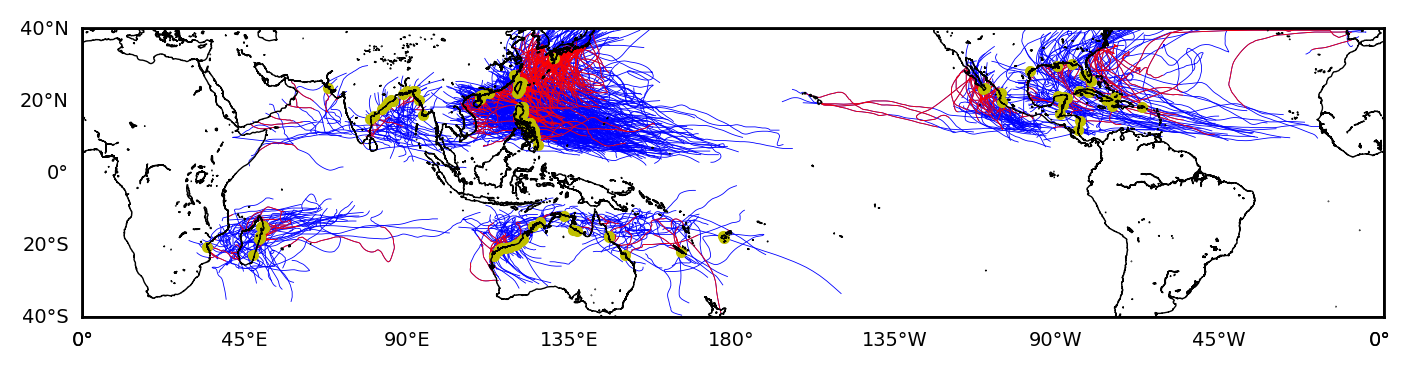

In [44]:
plt.close(); plt.figure(figsize=(7,2),dpi=200)
ax=[]
gs0  = gridspec.GridSpec(1, 1)
gs0.update(left=0.05, right=0.98, bottom=0.1, top=0.9, hspace=0.06, wspace=0.1)
ax.append(plt.subplot(gs0[0, 0]))
fontsize = 7
#### density map plot
# draw base maps
m = Basemap(projection='cyl', llcrnrlat=-40, urcrnrlat=40,llcrnrlon=0, urcrnrlon=361,resolution='i',ax=ax[0])
_ = m.drawcoastlines(linewidth=.5,color='k',zorder=10)
_ = m.drawmapboundary(fill_color='w')
_ = m.fillcontinents(color='none',lake_color='none')
_ = m.drawmeridians(np.arange(0,361,45),labels=[0,0,0,1],linewidth=0.,fontsize=fontsize)
_ = m.drawparallels(np.arange(-40,41,20),labels=[1,0,0,0],linewidth=0.,fontsize=fontsize)
#
def plot_track(x):
    tmp_lon = x.USA_LON.values
    tmp_lat = x.USA_LAT.values
    tmp_lon [tmp_lon<0] = tmp_lon [tmp_lon<0] + 360
    _=ax[0].plot(x.USA_LON,x.USA_LAT,lw=.3,color='b',zorder=1)
    #
    RRR_LMI= x.iloc[::-1].USA_WIND.idxmax()
    tmp_x=x[x.LF_MARKER==1]
    RRR_LF = tmp_x.USA_WIND.idxmax()
    pick = x[(x.index>=RRR_LMI)&(x.index<=RRR_LF)]
    tmp_lat  = pick.USA_LAT.values[:]
    tmp_lon  = pick.USA_LON.values[:]
    _=ax[0].plot(tmp_lon,tmp_lat,lw=.3,color='red',zorder=2)
    #
    #if pick.USA_WIND.values[-1]*0.5144444>=np.nanpercentile(LI_inverse,90):
    if pick.USA_WIND.values[-1]*0.5144444>=50:
        _=ax[0].plot(tmp_lon[-1],tmp_lat[-1],'oy',lw=.3,ms=3,zorder=3,alpha=1)
    
_=newbt_lf.groupby('SID').apply(lambda x: plot_track(x))

plt.savefig('/home/sw1013/www/FIGURES/Figure_supp.png',bbox_inches='tight', format='pdf',dpi=600)
plt.savefig('/home/sw1013/www/FIGURES/Figure_supp.pdf',bbox_inches='tight', format='pdf',dpi=600)

<hr>

**Figure 4**

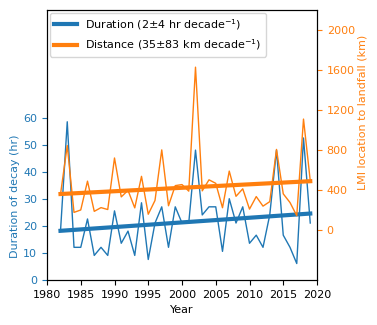

In [45]:
fig,ax=plt.subplots(1,1); fig.set_size_inches(3,3); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(100); 
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.4,hspace=0.3); fontsize = 8
#
X = INDEX_year[:]
Y = []
sample_weight = []
for YEAR in X:
    tmp = []
    for CCC in range(len(VMAX_PMIN_SERIES)):
        if (year_inverse[CCC] == YEAR):# & (VMAX_PMIN_SERIES[CCC][0]>=CAT_KT.CAT3.LOWER):
            tmp.extend([dur_inverse[CCC]])
    Y.extend([np.nanmedian(tmp)])
    sample_weight.extend([len(tmp)])
_=ax.plot(X,Y,'-C0',lw=1)
x_trend, y_trend,slope,ci,_ = get_trend_and_ci_weight(X,Y,sample_weight)
lns1=ax.plot(x_trend,y_trend,'-',lw=3,color='C0',label='Duration ('+str(int(round(slope*10)))+'±'+str(int(round(ci*10)))+' hr decade$^{-1}$)')
_=ax.tick_params(axis='both', which='major', labelsize=fontsize)
#_=ax.legend(fontsize=fontsize,loc=2,handlelength=1.6)
_=ax.set_xticks(range(1980,2021,5))
_=ax.set_ylim([0,100])
_=ax.set_yticks(np.arange(0,70,10))
_=ax.set_yticklabels(np.arange(0,70,10),fontsize=fontsize,color='C0')
_=ax.tick_params(axis='y', colors='C0')
_=ax.set_xlabel('Year',fontsize=fontsize)
_=ax.set_ylabel('Duration of decay (hr)',fontsize=fontsize,color='C0')
#_=ax.text(1975,110,'a',fontsize=fontsize,fontweight='bold')

bx=ax.twinx()
_=bx.plot([-100000,-200000],[-100000,-200000],'-',lw=3,color='k',label='Duration ('+str(int(round(slope*10)))+'±'+str(int(round(ci*10)))+' hr decade$^{-1}$)')

X = INDEX_year[:]
Y = []
sample_weight = []
for YEAR in X:
    tmp = []
    for CCC in range(len(VMAX_PMIN_SERIES)):
        if (VMAX_PMIN_SERIES[CCC][2] == YEAR):# & (VMAX_PMIN_SERIES[CCC][0]>=CAT_KT.CAT3.LOWER):
            tmp.extend([trajectory_inverse[CCC]])
    Y.extend([np.nanmedian(tmp)])
    sample_weight.extend([len(tmp)])
_=bx.plot(X,Y,'-C1',lw=1)
x_trend, y_trend,slope,ci,_ = get_trend_and_ci_weight(X,Y,sample_weight)
lns2=bx.plot(x_trend,y_trend,'-',lw=3,color='C1',label='Distance ('+str(int(round(slope*10)))+'±'+str(int(round(ci*10)))+' km decade$^{-1}$)')
_=bx.tick_params(axis='both', which='major', labelsize=fontsize)
#_=bx.legend(fontsize=fontsize,loc=2,handlelength=1.6)
_=bx.set_xticks(range(1980,2021,5))
_=bx.set_ylim([-500,2200])
_=bx.set_xlim([1980,2020])
_=bx.set_yticks(np.arange(0,2001,400))
_=bx.set_yticklabels(np.arange(0,2001,400),fontsize=fontsize,color='C1')
_=bx.tick_params(axis='y', colors='C1')
_=bx.set_xlabel('Year',fontsize=fontsize)
_=bx.set_ylabel('LMI location to landfall (km)',fontsize=fontsize,color='C1')

_=bx.yaxis.set_label_coords(1.15,0.62)
_=ax.yaxis.set_label_coords(-0.1,0.31)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
_=ax.legend(lns, labs, fontsize=fontsize,loc=2,bbox_to_anchor=[-.01,1.01])

plt.savefig('/home/sw1013/www/FIGURES/Figure_supp.png',dpi=600,bbox_inches='tight')
plt.savefig('/home/sw1013/www/FIGURES/Figure_supp.pdf',dpi=600,bbox_inches='tight')

1625.39424206213
53.18181818181818
1.3752445850759576
0.009233803314944776


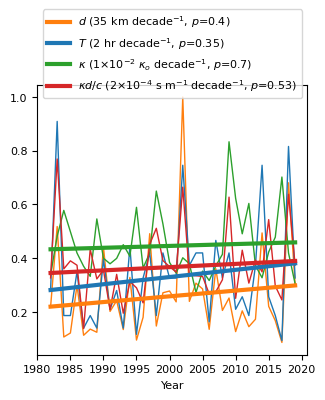

In [46]:
fig,ax=plt.subplots(1,1); fig.set_size_inches(3,3); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(100); 
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.4,hspace=0.3); fontsize = 8
#
X = INDEX_year[:]
Y = []
sample_weight = []
for YEAR in X:
    tmp = []
    for CCC in range(len(VMAX_PMIN_SERIES)):
        if (VMAX_PMIN_SERIES[CCC][2] == YEAR):# & (VMAX_PMIN_SERIES[CCC][0]>=CAT_KT.CAT3.LOWER):
            tmp.extend([trajectory_inverse[CCC]])
    Y.extend([np.nanmedian(tmp)])
    sample_weight.extend([len(tmp)])
_=ax.plot(X,Y/np.max(Y),'-C1',lw=1,zorder=4)
print(np.max(Y))
x_trend, y_trend,slope,ci,p = get_trend_and_ci_weight(X,Y,sample_weight)
_=ax.plot(x_trend,y_trend/np.max(Y),'-',lw=3,color='C1',label='$d$ ('+str(int(round(slope*10)))+' km decade$^{-1}$, $p$='+str(round(p,2))+')',zorder=5)
#
Y = []
sample_weight = []
for YEAR in X:
    tmp = []
    for CCC in range(len(VMAX_PMIN_SERIES)):
        if (year_inverse[CCC] == YEAR):# & (VMAX_PMIN_SERIES[CCC][0]>=CAT_KT.CAT3.LOWER):
            tmp.extend([dur_inverse[CCC]])
    Y.extend([np.nanmedian(tmp)])
    sample_weight.extend([len(tmp)])
_=ax.plot(X,Y/np.max(Y)/1.1,'-C0',lw=1,zorder=4)
print(np.max(Y)/1.1)
x_trend, y_trend,slope,ci,p = get_trend_and_ci_weight(X,Y,sample_weight)
_=ax.plot(x_trend,y_trend/np.max(Y)/1.1,'-',lw=3,color='C0',label='$T$ ('+str(int(round(slope*10)))+' hr decade$^{-1}$, $p$='+str(round(p,2))+')',zorder=5)
#
Y = []
sample_weight = []
for YEAR in X:
    tmp = []
    for CCC in range(len(VMAX_PMIN_SERIES)):
        if (VMAX_PMIN_SERIES[CCC][2] == YEAR):# & (VMAX_PMIN_SERIES[CCC][0]>=CAT_KT.CAT3.LOWER):
            tmp.extend([B_inverse[CCC]/Ref_B])
    Y.extend([np.nanmedian(tmp)])
    sample_weight.extend([len(tmp)])
_=ax.plot(X,Y/np.max(Y)/1.2,'-C2',lw=1,zorder=4)
print(np.max(Y)/1.2)
x_trend, y_trend,slope,ci,p = get_trend_and_ci_weight(X,Y,sample_weight)
_=ax.plot(x_trend,y_trend/np.max(Y)/1.2,'-',lw=3,color='C2',label='$\kappa$ ('+str(round(slope*10*1e2).astype(int))+'×10$^{-2}$ $\kappa_o$ decade$^{-1}$, $p$='+str(round(p,2))+')',zorder=5)
#
Y = []
sample_weight = []
for YEAR in X:
    tmp = []
    for CCC in range(len(VMAX_PMIN_SERIES)):
        if (VMAX_PMIN_SERIES[CCC][2] == YEAR):# & (VMAX_PMIN_SERIES[CCC][0]>=CAT_KT.CAT3.LOWER):
            tmp.extend([B_inverse[CCC]*dur_inverse[CCC]*3600])
    Y.extend([np.nanmedian(tmp)])
    sample_weight.extend([len(tmp)])
_=ax.plot(X,Y/np.max(Y)/1.3,'-C3',lw=1,zorder=4)
print(np.max(Y)/1.3)
x_trend, y_trend,slope,ci,p = get_trend_and_ci_weight(X,Y,sample_weight)
_=ax.plot(x_trend,y_trend/np.max(Y)/1.3,'-',lw=3,color='C3',label='$\kappa{d/c}$ ('+str(round(slope*10*1e4).astype(int))+'×10$^{-4}$ s m$^{-1}$ decade$^{-1}$, $p$='+str(round(p,2))+')',zorder=5)
#
_=ax.tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.legend(fontsize=fontsize,loc=2,bbox_to_anchor=(0.0,1.3))
_=ax.set_xticks(range(1980,2021,5))
#_=ax.set_ylim([0,100])
#_=ax.set_yticks(np.arange(0,70,10))
#_=ax.set_yticklabels(np.arange(0,70,10),fontsize=fontsize,color='C0')
_=ax.set_xlabel('Year',fontsize=fontsize)
_=ax.set_ylabel('',fontsize=fontsize)
#_=ax.text(1975,110,'a',fontsize=fontsize,fontweight='bold')
plt.savefig('/home/sw1013/www/FIGURES/Figure_supp3.png',dpi=600,bbox_inches='tight')
plt.savefig('/home/sw1013/www/FIGURES/Figure_supp3.pdf',dpi=600,bbox_inches='tight')

In [47]:
tmptmp_LMI = []
tmptmp_LI  = []
for CCC in range(len(B_inverse)):
    tmptmp_LMI.extend([interp_vmax_in_inverse[CCC][ 0]])
    tmptmp_LI .extend([interp_vmax_in_inverse[CCC][-1]])
tmptmp_LMI=np.asarray(tmptmp_LMI)
tmptmp_LI =np.asarray(tmptmp_LI )
np.nanmedian(tmptmp_LMI)
np.nanmedian(tmptmp_LI )
np.nanmedian(dur_inverse)

54.0162

36.0108

18.0

**Supp figure**

β=0.02±0.015
β=0.024±0.014
β=0.024±0.017


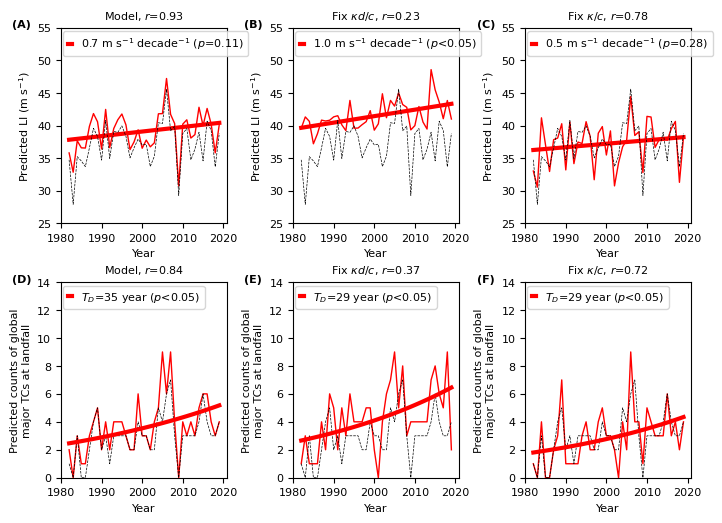

In [48]:
fig,ax=plt.subplots(2,3); fig.set_size_inches(7,5); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(100); 
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.4,hspace=0.3); fontsize = 8
#
tmp_dur = np.nanmedian(dur_inverse)
tmp_k   = np.nanmedian(B_inverse  [dur_inverse!=0])
tmp_lmi = np.nanmedian(A_inverse  )
#------------------------
X = INDEX_year[:]
Y = []
sample_weight = []
for YEAR in X:
    tmp = []
    for CCC in range(len(VMAX_PMIN_SERIES)):
        if (VMAX_PMIN_SERIES[CCC][2] == YEAR):# & (VMAX_PMIN_SERIES[CCC][0]<CAT_KT.CAT3.LOWER):
            tmp.extend([VMAX_PMIN_SERIES[CCC][1][-1]*.514444])
    Y.extend([np.nanmean(tmp)])
    sample_weight.extend([len(tmp)])
tmp_LI_obs = np.asarray(Y)
#-----------------------
X = INDEX_year[:]
Y = []
sample_weight = []
for YEAR in X:
    tmp = []
    for CCC in range(len(VMAX_PMIN_SERIES)):
        if (VMAX_PMIN_SERIES[CCC][2] == YEAR):# & (VMAX_PMIN_SERIES[CCC][0]<CAT_KT.CAT3.LOWER):
            tmp.extend([VMAX_PMIN_SERIES[CCC][1][-1]*.514444])
    tmp = np.asarray(tmp)
    Y.extend([sum(tmp>=96*.514444)])
    sample_weight.extend([1])
tmp_Major_obs = np.asarray(Y)
#------------------------
CORNOR = ['(A)','(B)','(C)','(D)','(E)','(F)','(G)','(H)','(I)','(J)']
for POS in range(3):
    tmp_pred_li = []
    for CCC in range(len(A_inverse)): 
        if POS == 0:
            if dur_inverse[CCC]!=0:
                tmp_pred_li.extend([func_inverse(np.arange(dur_inverse[CCC]*3600+1),A_inverse[CCC],B_inverse[CCC]) [-1]])
            else:
                tmp_pred_li.extend([A_inverse[CCC]])
            legend_str = 'Model'
        elif POS == 1:
            tmp_pred_li.extend([func_inverse(np.arange(tmp_dur*3600+1),A_inverse[CCC],tmp_k) [-1]])
            legend_str = 'Fix ${\kappa}d/c$'
        elif POS == 2:
            tmp_pred_li.extend([func_inverse(np.arange(trajectory_inverse[CCC]*1e3/np.median(speed_inverse[dur_inverse!=0])+1),A_inverse[CCC],tmp_k) [-1]])
            legend_str = 'Fix ${\kappa}/c$'
          
    tmp_pred_li = np.asarray(tmp_pred_li)
#-----------------------------------------------------------------------------------------------------------------------------------------------
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][2] == YEAR):# & (VMAX_PMIN_SERIES[CCC][0]<CAT_KT.CAT3.LOWER):
                tmp.extend([tmp_pred_li[CCC]])
        Y.extend([np.nanmean(tmp)])
        sample_weight.extend([len(tmp)])
    tmp_LI = np.asarray(Y)
    
    _=ax.flatten()[POS].plot(X,Y,'-',color='r',lw=1)
    x_trend, y_trend,slope,ci,p = get_trend_and_ci_weight(X,Y,sample_weight)
    kappa_str = '$\kappa$='+str(round(np.nanmedian(B_inverse)/Ref_B,1))+'$\kappa_o$'
    dur_str = 'Duration='+str(int(round(np.nanmedian(dur_inverse))))+' hr'
    _,_,detrend_r_str,_,_ = scipy.stats.linregress(scipy.signal.detrend(tmp_LI_obs),scipy.signal.detrend(tmp_LI))
    detrend_r_str = '$r$='+str('%.2f' %round(detrend_r_str,2))
    if p>=0.05:
        STR = '='+str(round(p,2))
    elif p<0.05:
        STR = '<0.05'
    _=ax.flatten()[POS].set_title(legend_str+', '+detrend_r_str,fontsize=fontsize)
    _=ax.flatten()[POS].plot(x_trend,y_trend,'-',lw=3,color='r',label=str(round(slope*10,1))+' m s$^{-1}$ decade$^{-1}$ ($p$'+STR+')')
    _=ax.flatten()[POS].plot(x_trend,tmp_LI_obs,'--k',lw=.5)
    _=ax.flatten()[POS].tick_params(axis='both', which='major', labelsize=fontsize)
    _=ax.flatten()[POS].legend(fontsize=fontsize,loc=2,handlelength=.4,bbox_to_anchor=[-.02,1.01])
    _=ax.flatten()[POS].set_xticks(range(1980,2021,10))
    _=ax.flatten()[POS].set_ylim([25,55])
    _=ax.flatten()[POS].set_xlabel('Year',fontsize=fontsize)
    _=ax.flatten()[POS].set_ylabel('Predicted LI (m s$^{-1}$)',fontsize=fontsize)
    _=ax.flatten()[POS].text(1968,55,CORNOR[POS],fontsize=fontsize,fontweight='bold')
    
    #scipy.stats.kstest(preprocessing.scale(y_trend-Y),'norm')
    #check_autocorrelation_durbin_watson(y_trend-Y)

#-----------------------------------------------------------------------------------------------------------------------------------------------  
    X = INDEX_year[:]
    Y = []
    sample_weight = []
    for YEAR in X:
        tmp = []
        for CCC in range(len(VMAX_PMIN_SERIES)):
            if (VMAX_PMIN_SERIES[CCC][2] == YEAR):# & (VMAX_PMIN_SERIES[CCC][0]<CAT_KT.CAT3.LOWER):
                tmp.extend([tmp_pred_li[CCC]])
        tmp = np.asarray(tmp)
        Y.extend([sum(tmp>=96*.514444)])
        sample_weight.extend([1])
    tmp_Major = np.asarray(Y)
    #++++++++++++++++++++++++++++++++++++print out the Poisson distribution fit stats of the count sample
    #chi2_poisson_fit(Y)
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    #print(Y)
    _=ax.flatten()[POS+3].plot(X,Y,'-',color='r',lw=1)
    #x_trend, y_trend,slope,ci = get_trend_and_ci_weight(X,Y,sample_weight)
    kappa_str = '$\kappa$='+str(round(np.nanmedian(B_inverse)/Ref_B,1))+'$\kappa_o$'
    dur_str = 'Duration='+str(int(round(np.nanmedian(dur_inverse))))+' hr'
    _,_,detrend_r_str,_,_ = scipy.stats.linregress(scipy.signal.detrend(tmp_Major_obs),scipy.signal.detrend(tmp_Major))
    detrend_r_str = '$r$='+str('%.2f' %round(detrend_r_str,2))
    _=ax.flatten()[POS+3].set_title(legend_str+', '+detrend_r_str,fontsize=fontsize)
    #_=ax.flatten()[POS+3].plot(x_trend,y_trend,'-',lw=3,color='r',label=str(round(slope*10,1))+'±'+str(round(ci*10,1))+' count decade$^{-1}$')
    
    pred, mean, ci,p = poisson_reg(X,Y)
    STR = ''
    if abs(ci)<=abs(mean):
        STR = ' ($p$<0.05)'
    _=ax.flatten()[POS+3].plot(X,pred,'-',color='r',lw=3,label='$T_D$='+str(round(np.log(2)/mean).astype(int))+' year'+STR,zorder=7)
    print('β='+str(round(mean,3))+'±'+str(round(ci,3)))
    
    _=ax.flatten()[POS+3].plot(x_trend,tmp_Major_obs,'--k',lw=.5)
    _=ax.flatten()[POS+3].tick_params(axis='both', which='major', labelsize=fontsize)
    _=ax.flatten()[POS+3].legend(fontsize=fontsize,loc=2,handlelength=.4,bbox_to_anchor=[-.02,1.01])
    _=ax.flatten()[POS+3].set_xticks(range(1980,2021,10))
    _=ax.flatten()[POS+3].set_ylim([0,14])
    _=ax.flatten()[POS+3].set_xlabel('Year',fontsize=fontsize)
    _=ax.flatten()[POS+3].set_ylabel('Predicted counts of global\nmajor TCs at landfall',fontsize=fontsize)
    _=ax.flatten()[POS+3].text(1968,14,CORNOR[POS+3],fontsize=fontsize,fontweight='bold')
    
    #scipy.stats.kstest(preprocessing.scale(y_trend-Y),'norm')
    #check_autocorrelation_durbin_watson(y_trend-Y)
    #scipy.stats.kstest(preprocessing.scale(pred-Y),'norm')
    #check_autocorrelation_durbin_watson(pred-Y)

#-----------------------------------------------------------------------------------------------------------------------------------------------
plt.savefig('/home/sw1013/www/FIGURES/Figure_supp2.png',dpi=600,bbox_inches='tight')
plt.savefig('/home/sw1013/www/FIGURES/Figure_supp2.pdf',dpi=600,bbox_inches='tight')

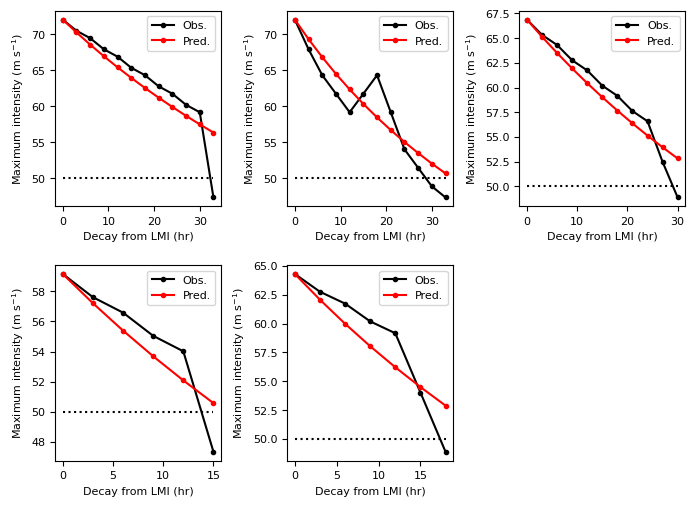

In [49]:
tmp_obs = []
tmp_pred = []
for YEAR in X:
    tmp = []
    for CCC in range(len(VMAX_PMIN_SERIES)):
        if (YEAR == 2005) & (VMAX_PMIN_SERIES[CCC][2] == 2005) & (vmax_pred_inverse[CCC][-1]>=96*0.5144444) & (VMAX_PMIN_SERIES[CCC][1][-1]<96) & (dur_inverse[CCC]!=0):
            tmp_obs .append(vmax_in_inverse[CCC])
            tmp_pred.append(vmax_pred_inverse[CCC])

tmp = (tmp_pred[1]-tmp_pred[1].min())* 0.95
tmp_pred[1] = (tmp_obs[1].max()-tmp.max())+tmp 
            
fig,ax=plt.subplots(2,3); fig.set_size_inches(7,5); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(100); 
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.4,hspace=0.3); fontsize = 8

for POS in range(len(tmp_obs)):
    _=ax.flatten()[POS].plot(3*np.arange(len(tmp_obs [POS])),tmp_obs [POS],'-ok',ms=3,label='Obs.')
    _=ax.flatten()[POS].plot(3*np.arange(len(tmp_pred[POS])),tmp_pred[POS],'-or',ms=3,label='Pred.')
    _=ax.flatten()[POS].set_xlabel('Decay from LMI (hr)',fontsize=fontsize)
    _=ax.flatten()[POS].set_ylabel('Maximum intensity (m s$^{-1}$)',fontsize=fontsize)
    _=ax.flatten()[POS].plot([0,3*np.arange(len(tmp_obs [POS]))[-1]],[50,50],':k')
    _=ax.flatten()[POS].legend(fontsize=fontsize)
    _=ax.flatten()[POS].tick_params(axis='both', which='major', labelsize=fontsize)
    #_=ax.flatten()[POS]

fig.delaxes(ax.flatten()[-1])
    
plt.savefig('/home/sw1013/www/FIGURES/Figure_reviewer2.png',dpi=600,bbox_inches='tight')
plt.savefig('/home/sw1013/www/FIGURES/Figure_reviewer2.pdf',dpi=600,bbox_inches='tight')

<hr>

## ERA5 - case mean annual trend - from LMI to LF

**I/O: ERA5 read in**

In [50]:
ERA5_U_00_fh   = Dataset('/net/wrfstore7-10/disk1/sw1013/ERA5/u_00061218.nc'  )
ERA5_U_03_fh   = Dataset('/net/wrfstore7-10/disk1/sw1013/ERA5/u_03091521.nc'  )
ERA5_V_00_fh   = Dataset('/net/wrfstore7-10/disk1/sw1013/ERA5/v_00061218.nc'  )
ERA5_V_03_fh   = Dataset('/net/wrfstore7-10/disk1/sw1013/ERA5/v_03091521.nc'  )
#ERA5_R_00_fh   = Dataset('/net/wrfstore7-10/disk1/sw1013/ERA5/r_00061218.nc'  )
#ERA5_R_03_fh   = Dataset('/net/wrfstore7-10/disk1/sw1013/ERA5/r_03091521.nc'  )
ERA5_SST_00_fh = Dataset('/net/wrfstore7-10/disk1/sw1013/ERA5/sst_00061218.nc')
ERA5_SST_03_fh = Dataset('/net/wrfstore7-10/disk1/sw1013/ERA5/sst_03091521.nc')
ERA5_TD2M_00_fh= Dataset('/net/wrfstore7-10/disk1/sw1013/ERA5/td2m_00061218.nc'  )
ERA5_TD2M_03_fh= Dataset('/net/wrfstore7-10/disk1/sw1013/ERA5/td2m_03091521.nc'  )
ERA5_T2M_00_fh = Dataset('/net/wrfstore7-10/disk1/sw1013/ERA5/t2m_00061218.nc'  )
ERA5_T2M_03_fh = Dataset('/net/wrfstore7-10/disk1/sw1013/ERA5/t2m_03091521.nc'  )
ERA5_SP_00_fh  = Dataset('/net/wrfstore7-10/disk1/sw1013/ERA5/sp_00061218.nc'  )
ERA5_SP_03_fh  = Dataset('/net/wrfstore7-10/disk1/sw1013/ERA5/sp_03091521.nc'  )

TIME_00_SINCE_1900 = ERA5_U_00_fh.variables['time'][:]
TIME_03_SINCE_1900 = ERA5_U_03_fh.variables['time'][:]

LAT=ERA5_U_00_fh.variables['latitude']
LON=ERA5_U_00_fh.variables['longitude']
LON,LAT = np.meshgrid(LON,LAT)

**DEF: find_shear_one_record(x)**

In [51]:
def find_shear_one_record(x):
    C_LAT = x.USA_LAT
    C_LON = x.USA_LON
    TIME  = x.ISO_TIME
    #print(x.SEASON.values[0])
    tmp_time = datetime.strptime(TIME, "%Y-%m-%d %H:%M:%S") - datetime.strptime("1900-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
    TIME_SPOT = int(tmp_time.days*24+tmp_time.seconds/3600)
    TIME_READ_00 = np.nanargmin(abs(TIME_SPOT-TIME_00_SINCE_1900))
    TIME_READ_03 = np.nanargmin(abs(TIME_SPOT-TIME_03_SINCE_1900))
    
    if np.min(abs(TIME_SPOT-TIME_00_SINCE_1900))<=np.min(abs(TIME_SPOT-TIME_03_SINCE_1900)):
        TIME_READ = TIME_READ_00
        U200=ERA5_U_00_fh  .variables['u'  ][TIME_READ,0].data
        U850=ERA5_U_00_fh  .variables['u'  ][TIME_READ,1].data
        V200=ERA5_V_00_fh  .variables['v'  ][TIME_READ,0].data
        V850=ERA5_V_00_fh  .variables['v'  ][TIME_READ,1].data
        #R700=ERA5_R_00_fh  .variables['r'  ][TIME_READ,0].data
        #R850=ERA5_R_00_fh  .variables['r'  ][TIME_READ,1].data
        SST =ERA5_SST_00_fh.variables['sst'][TIME_READ  ].data
    else:
        TIME_READ = TIME_READ_03
        U200=ERA5_U_03_fh  .variables['u'  ][TIME_READ,0].data
        U850=ERA5_U_03_fh  .variables['u'  ][TIME_READ,1].data
        V200=ERA5_V_03_fh  .variables['v'  ][TIME_READ,0].data
        V850=ERA5_V_03_fh  .variables['v'  ][TIME_READ,1].data
        #R700=ERA5_R_03_fh  .variables['r'  ][TIME_READ,0].data
        #R850=ERA5_R_03_fh  .variables['r'  ][TIME_READ,1].data
        SST =ERA5_SST_03_fh.variables['sst'][TIME_READ  ].data
    
    DIST = np.sqrt((C_LAT-LAT)**2+(C_LON-LON)**2)
    DIST[(DIST<2) | (DIST>8)]=np.nan
    U200[np.isnan(DIST)]=np.nan
    U850[np.isnan(DIST)]=np.nan
    V200[np.isnan(DIST)]=np.nan
    V850[np.isnan(DIST)]=np.nan
    #R700[np.isnan(DIST)]=np.nan
    #R850[np.isnan(DIST)]=np.nan
    tmp_u200 = np.nanmean(U200)
    tmp_u850 = np.nanmean(U850)
    tmp_v200 = np.nanmean(V200)
    tmp_v850 = np.nanmean(V850)
    #tmp_r700 = np.nanmean(R700)
    #tmp_r850 = np.nanmean(R850)
    SHEAR=np.sqrt((tmp_u200-tmp_u850)**2+(tmp_v200-tmp_v850)**2)
    UPPERWIND = np.sqrt((tmp_u200)**2+(tmp_v200)**2)
    LOWERWIND = np.sqrt((tmp_u850)**2+(tmp_v850)**2)
    #LOWERHUMID= (tmp_r700+tmp_r850)/2
    
    DIST = np.sqrt((C_LAT-LAT)**2+(C_LON-LON)**2)
    DIST[DIST>8]=np.nan
    SST[np.isnan(DIST)]=np.nan
    SST[SST==-32767.0]=np.nan
    tmp_sst = np.nanmean(SST)
    SSTUNDER= tmp_sst
    
    return [SHEAR, UPPERWIND, LOWERWIND, np.nan,SSTUNDER]


**DEF: download_ERA5_calc_MPI(x)**
Only run this stript if you want to download the ERA5 data

In [52]:
def download_ERA5_calc_MPI(x):
    # YEAR,MONTH,DAY,HR are strings. e.g. YEAR:'2008'; MONTH:'06'; DAY:'09'; HR:'03'
    # LAT, LON are floating. e.g. LAT:21.2; LON:120.3
    
    OUTPUT_TAG = x['SID']+'_'+x['ISO_TIME'][0:4]+x['ISO_TIME'][5:7]+x['ISO_TIME'][8:10]+x['ISO_TIME'][11:13]+x['ISO_TIME'][14:16]+x['ISO_TIME'][17:19]
    utc = x['ISO_TIME']
    time0 = datetime.strptime(utc, "%Y-%m-%d %H:%M:%S")
    delta_sec = -3600*24*3
    lst   = datetime.strftime(time0+timedelta(0,delta_sec),"%Y-%m-%d %H:%M:%S")
    utc = lst
    
    YEAR  = utc[ 0: 4]
    MONTH = utc[ 5: 7]
    DAY   = utc[ 8:10]
    HR    = utc[11:13]
    LAT   = x['USA_LAT']
    LON   = x['USA_LON']
    
    if np.isnan(LAT) or np.isnan(LON):
        MPI = np.nan
    
    else:
        AREA_RADIUS = 0

        c = cdsapi.Client()
        c.retrieve(
            'reanalysis-era5-pressure-levels',
            {
                'product_type': 'reanalysis',
                'format': 'netcdf',
                'variable': ['specific_humidity', 'temperature'],
                'pressure_level': [
                '1', '2', '3',
                '5', '7', '10',
                '20', '30', '50',
                '70', '100', '125',
                '150', '175', '200',
                '225', '250', '300',
                '350', '400', '450',
                '500', '550', '600',
                '650', '700', '750',
                '775', '800', '825',
                '850', '875', '900',
                '925', '950', '975',
                '1000',
                ],
                'year': YEAR,
                'month': MONTH,
                'day': DAY,
                'time': HR+':00',
                'area': [
                    LAT+AREA_RADIUS, LON-AREA_RADIUS, LAT-AREA_RADIUS,
                    LON+AREA_RADIUS,
                ],
            },
            '/net/wrfstore7-10/disk1/sw1013/tmp/'+OUTPUT_TAG+'_AIR.nc')

        c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'format': 'netcdf',
            'variable': [
                'mean_sea_level_pressure', 'sea_surface_temperature',
            ],
            'year': YEAR,
                'month': MONTH,
                'day': DAY,
                'time': HR+':00',
                'area': [
                    LAT+AREA_RADIUS, LON-AREA_RADIUS, LAT-AREA_RADIUS,
                    LON+AREA_RADIUS,
                ],
            },
            '/net/wrfstore7-10/disk1/sw1013/tmp/'+OUTPUT_TAG+'_SURF.nc')

        fh = Dataset('/net/wrfstore7-10/disk1/sw1013/tmp/'+OUTPUT_TAG+'_AIR.nc')
        Q    =np.flip ( fh.variables['q'        ][:].data.squeeze() * 1.e3   )  # unit g/kg
        T    =np.flip ( fh.variables['t'        ][:].data.squeeze() - 273.15 )  # unit C
        P    =np.flip ( fh.variables['level'    ][:].data                    )  # unit hPa

        fh = Dataset('/net/wrfstore7-10/disk1/sw1013/tmp/'+OUTPUT_TAG+'_SURF.nc')
        MSL    =np.flip ( fh.variables['msl'        ][:].data.squeeze() / 1.e2   )  # unit hPa
        SST    =np.flip ( fh.variables['sst'        ][:].data.squeeze() - 273.15 )  # unit C

        #tmp = PMIN,VMAX,TO,IFL,RAT,CAPEMS,CAPEM,FAC
        tmp = pcmin(SST,MSL, P, T, Q)
    
    #x['MPI'] = MPI
    if ~np.isnan(tmp[1]):
        return tmp
    else:
        return np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan

**DEF: use_ERA5_calc_MPI(x)**
this stript only uses downloaded ERA5 data

In [53]:
def use_ERA5_calc_MPI(x):
    # YEAR,MONTH,DAY,HR are strings. e.g. YEAR:'2008'; MONTH:'06'; DAY:'09'; HR:'03'
    # LAT, LON are floating. e.g. LAT:21.2; LON:120.3
    
    OUTPUT_TAG = x['SID']+'_'+x['ISO_TIME'][0:4]+x['ISO_TIME'][5:7]+x['ISO_TIME'][8:10]+x['ISO_TIME'][11:13]+x['ISO_TIME'][14:16]+x['ISO_TIME'][17:19]
    utc = x['ISO_TIME']
    time0 = datetime.strptime(utc, "%Y-%m-%d %H:%M:%S")
    delta_sec = -3600*24*3
    lst   = datetime.strftime(time0+timedelta(0,delta_sec),"%Y-%m-%d %H:%M:%S")
    utc = lst
    
    YEAR  = utc[ 0: 4]
    MONTH = utc[ 5: 7]
    DAY   = utc[ 8:10]
    HR    = utc[11:13]
    LAT   = x['USA_LAT']
    LON   = x['USA_LON']
    
    if np.isnan(LAT) or np.isnan(LON):
        return np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan

    else:
        if []==glob.glob('/net/wrfstore7-10/disk1/sw1013/MPI_ERA5_BYCASE/'+OUTPUT_TAG+'_AIR.nc'):
            AREA_RADIUS = 0

            c = cdsapi.Client()
            c.retrieve(
                'reanalysis-era5-pressure-levels',
                {
                    'product_type': 'reanalysis',
                    'format': 'netcdf',
                    'variable': ['specific_humidity', 'temperature'],
                    'pressure_level': [
                    '1', '2', '3',
                    '5', '7', '10',
                    '20', '30', '50',
                    '70', '100', '125',
                    '150', '175', '200',
                    '225', '250', '300',
                    '350', '400', '450',
                    '500', '550', '600',
                    '650', '700', '750',
                    '775', '800', '825',
                    '850', '875', '900',
                    '925', '950', '975',
                    '1000',
                    ],
                    'year': YEAR,
                    'month': MONTH,
                    'day': DAY,
                    'time': HR+':00',
                    'area': [
                        LAT+AREA_RADIUS, LON-AREA_RADIUS, LAT-AREA_RADIUS,
                        LON+AREA_RADIUS,
                    ],
                },
                '/net/wrfstore7-10/disk1/sw1013/MPI_ERA5_BYCASE/'+OUTPUT_TAG+'_AIR.nc')

            c.retrieve(
            'reanalysis-era5-single-levels',
            {
                'product_type': 'reanalysis',
                'format': 'netcdf',
                'variable': [
                    'mean_sea_level_pressure', 'sea_surface_temperature',
                ],
                'year': YEAR,
                    'month': MONTH,
                    'day': DAY,
                    'time': HR+':00',
                    'area': [
                        LAT+AREA_RADIUS, LON-AREA_RADIUS, LAT-AREA_RADIUS,
                        LON+AREA_RADIUS,
                    ],
                },
                '/net/wrfstore7-10/disk1/sw1013/MPI_ERA5_BYCASE/'+OUTPUT_TAG+'_SURF.nc')
            
        fh = Dataset('/net/wrfstore7-10/disk1/sw1013/MPI_ERA5_BYCASE/'+OUTPUT_TAG+'_AIR.nc')
        Q    =np.flip ( fh.variables['q'        ][:].data.squeeze() * 1.e3   )  # unit g/kg
        T    =np.flip ( fh.variables['t'        ][:].data.squeeze() - 273.15 )  # unit C
        P    =np.flip ( fh.variables['level'    ][:].data                    )  # unit hPa

        fh = Dataset('/net/wrfstore7-10/disk1/sw1013/MPI_ERA5_BYCASE/'+OUTPUT_TAG+'_SURF.nc')
        MSL    =np.flip ( fh.variables['msl'        ][:].data.squeeze() / 1.e2   )  # unit hPa
        SST    =np.flip ( fh.variables['sst'        ][:].data.squeeze() - 273.15 )  # unit C

        #tmp = PMIN,VMAX,TO,IFL,RAT,CAPEMS,CAPEM,FAC
        tmp = pcmin(SST,MSL, P, T, Q)

        #x['MPI'] = MPI
        if ~np.isnan(tmp[1]):
            return tmp
        else:
            return np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
            

**DEF: CALC_MOVING_SPEED(tmp_lat,tmp_lon)**

In [54]:
def CALC_MOVING_SPEED(tmp_lat,tmp_lon):
    tmp_uv = np.nan * np.zeros(shape=tmp_lat.shape)
    for RRR in range(len(tmp_lat)-1):
        coords_1 = (tmp_lat[RRR  ], tmp_lon[RRR  ])
        coords_2 = (tmp_lat[RRR+1], tmp_lon[RRR+1])
        tmp_uv[RRR]   = geopy.distance.vincenty(coords_1, coords_2).m/6./3600.
    return tmp_uv

**DEF: keep_one_from_lmi_to_lf_fraction(x,FRAC)**

In [55]:
def keep_one_from_lmi_to_lf_fraction(x,FRAC):
    #print(x.SID.values[0])
    RRR_LMI= len(x)-np.nanargmax(x.iloc[::-1].USA_WIND.values)-1
    RRR_LF = np.nanargmax(x.LF_MARKER.values)
    
    RRR_LMI_tmp= x.iloc[::-1].USA_WIND.idxmax()
    tmp_x=x[x.LF_MARKER==1]
    RRR_LF_tmp = tmp_x.USA_WIND.idxmax()
        
    if RRR_LMI + FRAC <= RRR_LF and RRR_LF_tmp-RRR_LMI_tmp >= 1:
        RRR = RRR_LMI + FRAC
        output =  x.iloc[int(RRR)]
        tmp = find_shear_one_record(output)
        output['HOUR_TO_LF'] = 3*(RRR_LF-RRR)
        output['SHEAR'     ] = tmp[0]
        output['UPPERWIND' ] = tmp[1]
        output['LOWERWIND' ] = tmp[2]
        output['LOWERHUMID'] = tmp[3]
        output['SST'       ] = tmp[4]
        tmp = CALC_MOVING_SPEED(x.iloc[int(RRR-1):int(RRR+1)].USA_LAT.values,x.iloc[int(RRR-1):int(RRR+1)].USA_LON.values)
        output['TRANSLATION'       ] = tmp[0]
        # PMIN,VMAX,TO,IFL,RAT,CAPEMS,CAPEM,FAC
        tmp = use_ERA5_calc_MPI(output)
        #tmp = download_ERA5_calc_MPI(output)
        output['MPI3DAY'       ] = tmp[1]/0.514444
        output['TOUT3DAY'      ] = tmp[2]
        output['SST3DAY'       ] = tmp[2] * tmp[4] 
        output['CAPEMS'        ] = tmp[5]
        output['CAPEM'         ] = tmp[6]
        return output

In [ ]:
SPLIT_PERIOD = np.arange(0,131,1)
for tmp,FRAC in enumerate(SPLIT_PERIOD):
    print(FRAC)
    if tmp == 0:
        VAR = newbt_lf.groupby('SID').apply(lambda x: keep_one_from_lmi_to_lf_fraction(x,FRAC))
    else:
        VAR = VAR.append(newbt_lf.groupby('SID').apply(lambda x: keep_one_from_lmi_to_lf_fraction(x,FRAC)))
VARbackup = copy.copy(VAR)

In [57]:
VAR = copy.copy(VARbackup)
VAR=VAR.reset_index(level=0, drop=True)

In [58]:
SHEAR      = VAR.groupby('SID').apply(lambda x:np.nanmean(x.SHEAR))
LOWERHUMID = VAR.groupby('SID').apply(lambda x:np.nanmean(x.LOWERHUMID))
SST        = VAR.groupby('SID').apply(lambda x:np.nanmean(x.SST3DAY))
SEASON     = VAR.groupby('SID').apply(lambda x:np.nanmean(x.SEASON))
MPI        = VAR.groupby('SID').apply(lambda x:np.nanmean(x.MPI3DAY))
CLAT       = VAR.groupby('SID').apply(lambda x:np.nanmean(np.abs(x.LAT)))
TRANSLATION= VAR.groupby('SID').apply(lambda x:np.nanmean(x.TRANSLATION))
Sterm      = VAR.groupby('SID').apply(lambda x:np.nanmean( np.sqrt(abs(x.CAPEMS-x.CAPEM)) / np.sqrt(abs(x.SST3DAY-x.TOUT3DAY))  )) 
Tterm      = VAR.groupby('SID').apply(lambda x:np.nanmean( np.sqrt(abs(x.SST3DAY/x.TOUT3DAY*(x.SST3DAY-x.TOUT3DAY)))  ))
TOUTFLOW   = VAR.groupby('SID').apply(lambda x:np.nanmean( x.TOUT3DAY))
LMI        = VAR.groupby('SID').apply(lambda x:x.USA_WIND.values[0])
LI         = VAR.groupby('SID').apply(lambda x:x.USA_WIND.values[-1])
MPILMI     = VAR.groupby('SID').apply(lambda x:x.MPI3DAY.values[0])
SHEARLMI   = VAR.groupby('SID').apply(lambda x:x.SHEAR.values[0])
TtermLMI   = VAR.groupby('SID').apply(lambda x:np.sqrt(abs(x.SST3DAY.values[0]/x.TOUT3DAY.values[0]*(x.SST3DAY.values[0]-x.TOUT3DAY.values[0])))  )
StermLMI   = VAR.groupby('SID').apply(lambda x:np.sqrt(abs(x.CAPEMS.values[0]-x.CAPEM.values[0])) / np.sqrt(abs(x.SST3DAY.values[0]-x.TOUT3DAY.values[0]))  )
SSTLMI     = VAR.groupby('SID').apply(lambda x:x.SST3DAY.values[0])
TOUTFLOWLMI= VAR.groupby('SID').apply(lambda x:x.TOUT3DAY.values[0])

**Correlation bewteen decay factors and environment**

**Individual case correlation**

In [59]:
tmp_B     = np.asarray(B_inverse         )        [(~np.isnan(SST))&(~np.isnan(B_inverse))]
tmp_DIS   = np.asarray(trajectory_inverse)        [(~np.isnan(SST))&(~np.isnan(B_inverse))]
tmp_DUR   = np.asarray(dur_inverse       )        [(~np.isnan(SST))&(~np.isnan(B_inverse))]
tmp_LMI   = np.asarray(A_inverse         )        [(~np.isnan(SST))&(~np.isnan(B_inverse))]
tmp_LI    = np.asarray(LI                )        [(~np.isnan(SST))&(~np.isnan(B_inverse))]
tmp_SHEAR = np.asarray(SHEAR             )        [(~np.isnan(SST))&(~np.isnan(B_inverse))]
tmp_LAT   = np.asarray(CLAT              )        [(~np.isnan(SST))&(~np.isnan(B_inverse))]
tmp_V     = np.asarray(speed_inverse     )        [(~np.isnan(SST))&(~np.isnan(B_inverse))]
tmp_BDUR  = np.asarray(B_inverse*dur_inverse*3600)[(~np.isnan(SST))&(~np.isnan(B_inverse))]
tmp_MPI   = np.asarray(MPI               )        [(~np.isnan(SST))&(~np.isnan(B_inverse))]
tmp_SST   = np.asarray(SST               )        [(~np.isnan(SST))&(~np.isnan(B_inverse))]


TABLE = pd.DataFrame(index=['k','D','T','kT'],columns=['LMI','Lat','Shear','SST','MPI'])

def r_and_p(X,Y):
    _,_,r,p,_ = scipy.stats.linregress(scipy.signal.detrend(X),scipy.signal.detrend(Y))
    return str(round(r,2))+'('+str(round(p,2))+')'

TABLE.Lat.D   = r_and_p(tmp_LAT,tmp_DIS)
TABLE.Lat.T   = r_and_p(tmp_LAT,tmp_DUR)
TABLE.Lat.k          = r_and_p(tmp_LAT,tmp_B  )
TABLE.Lat.kT          = r_and_p(tmp_LAT,tmp_BDUR  )
TABLE.Shear.D = r_and_p(tmp_SHEAR,tmp_DIS)
TABLE.Shear.T = r_and_p(tmp_SHEAR,tmp_DUR)
TABLE.Shear.k        = r_and_p(tmp_SHEAR,tmp_B  )
TABLE.Shear.kT        = r_and_p(tmp_SHEAR,tmp_BDUR  )
TABLE.SST.D   = r_and_p(tmp_SST,tmp_DIS)
TABLE.SST.T   = r_and_p(tmp_SST,tmp_DUR)
TABLE.SST.k          = r_and_p(tmp_SST,tmp_B  )
TABLE.SST.kT          = r_and_p(tmp_SST,tmp_BDUR  )
TABLE.LMI.D   = r_and_p(tmp_LMI,tmp_DIS)
TABLE.LMI.T   = r_and_p(tmp_LMI,tmp_DUR)
TABLE.LMI.k          = r_and_p(tmp_LMI,tmp_B  )
TABLE.LMI.kT          = r_and_p(tmp_LMI,tmp_BDUR  )
TABLE.MPI.D   = r_and_p(tmp_MPI,tmp_DIS)
TABLE.MPI.T   = r_and_p(tmp_MPI,tmp_DUR)
TABLE.MPI.k          = r_and_p(tmp_MPI,tmp_B  )
TABLE.MPI.kT          = r_and_p(tmp_MPI,tmp_BDUR  )
TABLE

,LMI,Lat,Shear,SST,MPI
k,-0.47(0.0),0.01(0.79),0.09(0.02),-0.01(0.8),-0.01(0.7)
D,0.3(0.0),0.23(0.0),0.17(0.0),-0.35(0.0),-0.3(0.0)
T,0.29(0.0),0.1(0.01),0.08(0.04),-0.22(0.0),-0.2(0.0)
kT,-0.08(0.05),0.08(0.05),0.25(0.0),-0.38(0.0),-0.3(0.0)


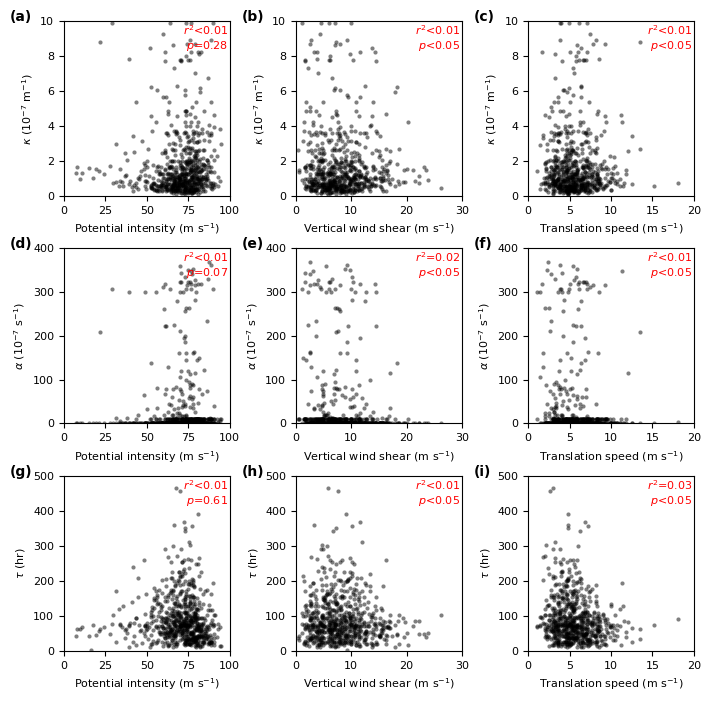

In [60]:
DUR_AT_LEAST_POINTS = 0


fig,ax=plt.subplots(3,3); fig.set_size_inches(7,7); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(100); 
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.4,hspace=0.3); fontsize = 8

tmp_C     = np.asarray(C_latent          )        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)]
tmp_B     = np.asarray(B_latent          )        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)]
tmp_DIS   = np.asarray(trajectory_inverse)        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)]
tmp_DUR   = np.asarray(dur_inverse       )        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)]
tmp_LMI   = np.asarray(A_inverse         )        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)]
tmp_LI    = np.asarray(LI                )        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)]
tmp_SHEAR = np.asarray(SHEAR             )        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)]
tmp_LAT   = np.asarray(CLAT              )        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)]
tmp_V     = np.asarray(speed_inverse     )        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)]
tmp_BDUR  = np.asarray(B_latent*dur_inverse*3600) [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)]
tmp_MPI   = np.asarray(MPI               )        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)]
tmp_SST   = np.asarray(SST               )        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)]

#
_=ax.flatten()[3].plot(tmp_MPI*0.514444,tmp_C/Ref_B,'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[3].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[3].set_ylabel('$α$ (10$^{-7}$ s$^{-1}$)',fontsize=fontsize)
_=ax.flatten()[3].set_xlabel('Potential intensity (m s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_MPI,tmp_C)
if p<0.05:
    p_str = '<0.05'
else:
    p_str = '='+str(round(p,2))
r_str = str('='+'%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str = '<0.01'
_=ax.flatten()[3].text(100*.99,400*.99,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='top',ha='right',color='r')
_=ax.flatten()[3].text(-32.5,400,'(d)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[3].set_ylim([0,400])
_=ax.flatten()[3].set_xlim([0,100])
#
_=ax.flatten()[4].plot(tmp_SHEAR,tmp_C/Ref_B,'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[4].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[4].set_ylabel('$α$ (10$^{-7}$ s$^{-1}$)',fontsize=fontsize)
_=ax.flatten()[4].set_xlabel('Vertical wind shear (m s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_SHEAR,tmp_C)
if p<0.05:
    p_str = '<0.05'
r_str = str('='+'%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str = '<0.01'
_=ax.flatten()[4].text(30*.99,400*.99,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='top',ha='right',color='r')
_=ax.flatten()[4].text(-9.75,400,'(e)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[4].set_ylim([0,400])
_=ax.flatten()[4].set_xlim([0,30])
#
_=ax.flatten()[5].plot(tmp_V,tmp_C/Ref_B,'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[5].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[5].set_ylabel('$α$ (10$^{-7}$ s$^{-1}$)',fontsize=fontsize)
_=ax.flatten()[5].set_xlabel('Translation speed (m s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_V,tmp_C)
if p<0.05:
    p_str = '<0.05'
r_str = str('='+'%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str = '<0.01'
_=ax.flatten()[5].text(20*.99,400*.99,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='top',ha='right',color='r')
_=ax.flatten()[5].text(-6.5,400,'(f)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[5].set_ylim([0,400])
_=ax.flatten()[5].set_xlim([0,20])

#====================================================================================================================

_=ax.flatten()[0].plot(tmp_MPI*0.514444,tmp_B/Ref_B,'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[0].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[0].set_ylabel('$κ$ (10$^{-7}$ m$^{-1}$)',fontsize=fontsize)
_=ax.flatten()[0].set_xlabel('Potential intensity (m s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_MPI,tmp_B)
if p<0.05:
    p_str = '<0.05'
else:
    p_str = '='+str(round(p,2))
r_str = str('='+'%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str = '<0.01'
_=ax.flatten()[0].text(100*.99,10*.99,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='top',ha='right',color='r')
_=ax.flatten()[0].text(-32.5,10,'(a)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[0].set_ylim([0,10])
_=ax.flatten()[0].set_xlim([0,100])
#_=ax.flatten()[0].set_xticks(np.arange(0,17,2))
#
_=ax.flatten()[1].plot(tmp_SHEAR,tmp_B/Ref_B,'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[1].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[1].set_ylabel('$κ$ (10$^{-7}$ m$^{-1}$)',fontsize=fontsize)
_=ax.flatten()[1].set_xlabel('Vertical wind shear (m s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_SHEAR,tmp_B)
if p<0.05:
    p_str = '<0.05'
r_str = str('='+'%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str = '<0.01'
_=ax.flatten()[1].text(30*.99,10*.99,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='top',ha='right',color='r')
_=ax.flatten()[1].text(-9.75,10,'(b)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[1].set_ylim([0,10])
_=ax.flatten()[1].set_xlim([0,30])
#
_=ax.flatten()[2].plot(tmp_V,tmp_B/Ref_B,'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[2].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[2].set_ylabel('$κ$ (10$^{-7}$ m$^{-1}$)',fontsize=fontsize)
_=ax.flatten()[2].set_xlabel('Translation speed (m s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_V,tmp_B)
if p<0.05:
    p_str = '<0.05'
r_str = str('='+'%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str = '<0.01'
_=ax.flatten()[2].text(20*.99,10*.99,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='top',ha='right',color='r')
_=ax.flatten()[2].text(-6.5,10,'(c)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[2].set_ylim([0,10])
_=ax.flatten()[2].set_xlim([0,20])

#====================================================================================================================

tmp_B     = np.asarray(B_exp             )        [(~np.isnan(SST))&(~np.isnan(B_exp))&(~np.isnan(speed_inverse))&(dur_exp>=DUR_AT_LEAST_POINTS)]
tmp_DIS   = np.asarray(trajectory_inverse)        [(~np.isnan(SST))&(~np.isnan(B_exp))&(~np.isnan(speed_inverse))&(dur_exp>=DUR_AT_LEAST_POINTS)]
tmp_DUR   = np.asarray(dur_inverse       )        [(~np.isnan(SST))&(~np.isnan(B_exp))&(~np.isnan(speed_inverse))&(dur_exp>=DUR_AT_LEAST_POINTS)]
tmp_LMI   = np.asarray(A_inverse         )        [(~np.isnan(SST))&(~np.isnan(B_exp))&(~np.isnan(speed_inverse))&(dur_exp>=DUR_AT_LEAST_POINTS)]
tmp_LI    = np.asarray(LI                )        [(~np.isnan(SST))&(~np.isnan(B_exp))&(~np.isnan(speed_inverse))&(dur_exp>=DUR_AT_LEAST_POINTS)]
tmp_SHEAR = np.asarray(SHEAR             )        [(~np.isnan(SST))&(~np.isnan(B_exp))&(~np.isnan(speed_inverse))&(dur_exp>=DUR_AT_LEAST_POINTS)]
tmp_LAT   = np.asarray(CLAT              )        [(~np.isnan(SST))&(~np.isnan(B_exp))&(~np.isnan(speed_inverse))&(dur_exp>=DUR_AT_LEAST_POINTS)]
tmp_V     = np.asarray(speed_inverse     )        [(~np.isnan(SST))&(~np.isnan(B_exp))&(~np.isnan(speed_inverse))&(dur_exp>=DUR_AT_LEAST_POINTS)]
tmp_MPI   = np.asarray(MPI               )        [(~np.isnan(SST))&(~np.isnan(B_exp))&(~np.isnan(speed_inverse))&(dur_exp>=DUR_AT_LEAST_POINTS)]
tmp_SST   = np.asarray(SST               )        [(~np.isnan(SST))&(~np.isnan(B_exp))&(~np.isnan(speed_inverse))&(dur_exp>=DUR_AT_LEAST_POINTS)]

tmp_B = 1/tmp_B

#
_=ax.flatten()[6].plot(tmp_MPI*0.514444,tmp_B,'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[6].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[6].set_ylabel('$τ$ (hr)',fontsize=fontsize)
_=ax.flatten()[6].set_xlabel('Potential intensity (m s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_MPI,tmp_B)
if p<0.05:
    p_str = '<0.05'
else:
    p_str = '='+str(round(p,2))
r_str = str('='+'%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str = '<0.01'
_=ax.flatten()[6].text(100*.99,500*.99,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='top',ha='right',color='r')
_=ax.flatten()[6].text(-32.5,500,'(g)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[6].set_ylim([0,500])
_=ax.flatten()[6].set_xlim([0,100])
#_=ax.flatten()[6].set_xticks(np.arange(0,17,2))
#
_=ax.flatten()[7].plot(tmp_SHEAR,tmp_B,'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[7].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[7].set_ylabel('$τ$ (hr)',fontsize=fontsize)
_=ax.flatten()[7].set_xlabel('Vertical wind shear (m s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_SHEAR,tmp_B)
p_str = '='+str(np.round(p,2))
if p<0.05:
    p_str = '<0.05'
r_str = str('='+'%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str = '<0.01'
_=ax.flatten()[7].text(30*.99,500*.99,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='top',ha='right',color='r')
_=ax.flatten()[7].text(-9.75,500,'(h)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[7].set_ylim([0,500])
_=ax.flatten()[7].set_xlim([0,30])
#
_=ax.flatten()[8].plot(tmp_V,tmp_B,'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[8].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[8].set_ylabel('$τ$ (hr)',fontsize=fontsize)
_=ax.flatten()[8].set_xlabel('Translation speed (m s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_V,tmp_B)
p_str = '='+str(np.round(p,2))
if p<0.05:
    p_str = '<0.05'
r_str = str('='+'%.2f' %np.round(r**2,2))
_=ax.flatten()[8].text(20*.99,500*.99,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='top',ha='right',color='r')
_=ax.flatten()[8].text(-6.5,500,'(i)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[8].set_ylim([0,500])
_=ax.flatten()[8].set_xlim([0,20])

plt.savefig('/home/sw1013/www/FIGURES/Decay_Figure_3.png',dpi=600,bbox_inches='tight')
plt.savefig('/home/sw1013/www/FIGURES/Decay_Figure_3.pdf',dpi=600,bbox_inches='tight')

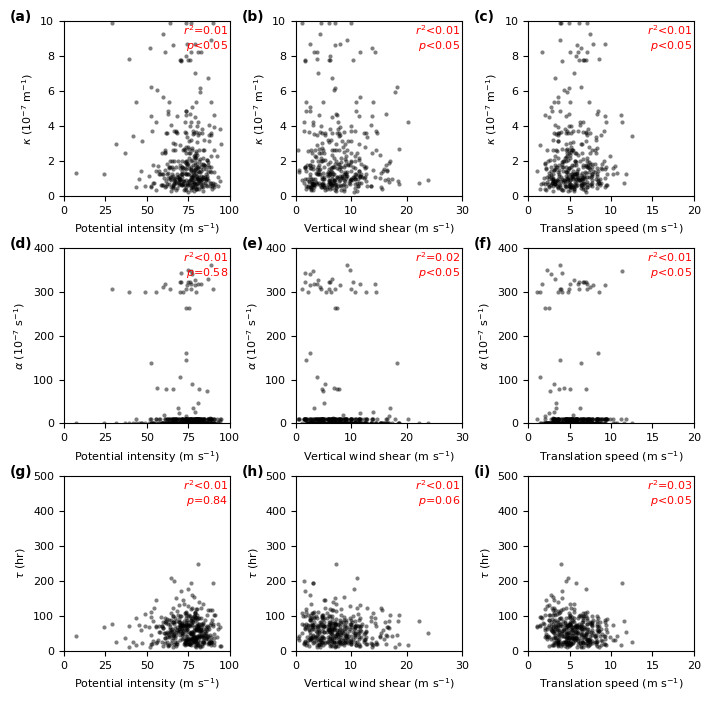

In [76]:
DUR_AT_LEAST_POINTS = 0


fig,ax=plt.subplots(3,3); fig.set_size_inches(7,7); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(100); 
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.4,hspace=0.3); fontsize = 8

tmp_C     = np.asarray(C_latent          )        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]
tmp_B     = np.asarray(B_latent          )        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]
tmp_DIS   = np.asarray(trajectory_inverse)        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]
tmp_DUR   = np.asarray(dur_inverse       )        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]
tmp_LMI   = np.asarray(A_inverse         )        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]
tmp_LI    = np.asarray(LI                )        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]
tmp_SHEAR = np.asarray(SHEAR             )        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]
tmp_LAT   = np.asarray(CLAT              )        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]
tmp_V     = np.asarray(speed_inverse     )        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]
tmp_BDUR  = np.asarray(B_latent*dur_inverse*3600) [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]
tmp_MPI   = np.asarray(MPI               )        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]
tmp_SST   = np.asarray(SST               )        [(~np.isnan(SST))&(B_latent<25e-7)&(dur_inverse>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]

#
_=ax.flatten()[3].plot(tmp_MPI*0.514444,tmp_C/Ref_B,'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[3].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[3].set_ylabel('$α$ (10$^{-7}$ s$^{-1}$)',fontsize=fontsize)
_=ax.flatten()[3].set_xlabel('Potential intensity (m s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_MPI,tmp_C)
if p<0.05:
    p_str = '<0.05'
else:
    p_str = '='+str(round(p,2))
r_str = str('='+'%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str = '<0.01'
_=ax.flatten()[3].text(100*.99,400*.99,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='top',ha='right',color='r')
_=ax.flatten()[3].text(-32.5,400,'(d)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[3].set_ylim([0,400])
_=ax.flatten()[3].set_xlim([0,100])
#
_=ax.flatten()[4].plot(tmp_SHEAR,tmp_C/Ref_B,'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[4].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[4].set_ylabel('$α$ (10$^{-7}$ s$^{-1}$)',fontsize=fontsize)
_=ax.flatten()[4].set_xlabel('Vertical wind shear (m s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_SHEAR,tmp_C)
if p<0.05:
    p_str = '<0.05'
r_str = str('='+'%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str = '<0.01'
_=ax.flatten()[4].text(30*.99,400*.99,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='top',ha='right',color='r')
_=ax.flatten()[4].text(-9.75,400,'(e)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[4].set_ylim([0,400])
_=ax.flatten()[4].set_xlim([0,30])
#
_=ax.flatten()[5].plot(tmp_V,tmp_C/Ref_B,'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[5].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[5].set_ylabel('$α$ (10$^{-7}$ s$^{-1}$)',fontsize=fontsize)
_=ax.flatten()[5].set_xlabel('Translation speed (m s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_V,tmp_C)
if p<0.05:
    p_str = '<0.05'
r_str = str('='+'%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str = '<0.01'
_=ax.flatten()[5].text(20*.99,400*.99,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='top',ha='right',color='r')
_=ax.flatten()[5].text(-6.5,400,'(f)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[5].set_ylim([0,400])
_=ax.flatten()[5].set_xlim([0,20])

#====================================================================================================================

_=ax.flatten()[0].plot(tmp_MPI*0.514444,tmp_B/Ref_B,'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[0].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[0].set_ylabel('$κ$ (10$^{-7}$ m$^{-1}$)',fontsize=fontsize)
_=ax.flatten()[0].set_xlabel('Potential intensity (m s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_MPI,tmp_B)
if p<0.05:
    p_str = '<0.05'
else:
    p_str = '='+str(round(p,2))
r_str = str('='+'%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str = '<0.01'
_=ax.flatten()[0].text(100*.99,10*.99,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='top',ha='right',color='r')
_=ax.flatten()[0].text(-32.5,10,'(a)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[0].set_ylim([0,10])
_=ax.flatten()[0].set_xlim([0,100])
#_=ax.flatten()[0].set_xticks(np.arange(0,17,2))
#
_=ax.flatten()[1].plot(tmp_SHEAR,tmp_B/Ref_B,'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[1].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[1].set_ylabel('$κ$ (10$^{-7}$ m$^{-1}$)',fontsize=fontsize)
_=ax.flatten()[1].set_xlabel('Vertical wind shear (m s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_SHEAR,tmp_B)
if p<0.05:
    p_str = '<0.05'
r_str = str('='+'%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str = '<0.01'
_=ax.flatten()[1].text(30*.99,10*.99,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='top',ha='right',color='r')
_=ax.flatten()[1].text(-9.75,10,'(b)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[1].set_ylim([0,10])
_=ax.flatten()[1].set_xlim([0,30])
#
_=ax.flatten()[2].plot(tmp_V,tmp_B/Ref_B,'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[2].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[2].set_ylabel('$κ$ (10$^{-7}$ m$^{-1}$)',fontsize=fontsize)
_=ax.flatten()[2].set_xlabel('Translation speed (m s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_V,tmp_B)
if p<0.05:
    p_str = '<0.05'
r_str = str('='+'%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str = '<0.01'
_=ax.flatten()[2].text(20*.99,10*.99,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='top',ha='right',color='r')
_=ax.flatten()[2].text(-6.5,10,'(c)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[2].set_ylim([0,10])
_=ax.flatten()[2].set_xlim([0,20])

#====================================================================================================================

tmp_B     = np.asarray(B_exp             )        [(~np.isnan(SST))&(~np.isnan(B_exp))&(~np.isnan(speed_inverse))&(dur_exp>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]
tmp_DIS   = np.asarray(trajectory_inverse)        [(~np.isnan(SST))&(~np.isnan(B_exp))&(~np.isnan(speed_inverse))&(dur_exp>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]
tmp_DUR   = np.asarray(dur_inverse       )        [(~np.isnan(SST))&(~np.isnan(B_exp))&(~np.isnan(speed_inverse))&(dur_exp>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]
tmp_LMI   = np.asarray(A_inverse         )        [(~np.isnan(SST))&(~np.isnan(B_exp))&(~np.isnan(speed_inverse))&(dur_exp>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]
tmp_LI    = np.asarray(LI                )        [(~np.isnan(SST))&(~np.isnan(B_exp))&(~np.isnan(speed_inverse))&(dur_exp>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]
tmp_SHEAR = np.asarray(SHEAR             )        [(~np.isnan(SST))&(~np.isnan(B_exp))&(~np.isnan(speed_inverse))&(dur_exp>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]
tmp_LAT   = np.asarray(CLAT              )        [(~np.isnan(SST))&(~np.isnan(B_exp))&(~np.isnan(speed_inverse))&(dur_exp>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]
tmp_V     = np.asarray(speed_inverse     )        [(~np.isnan(SST))&(~np.isnan(B_exp))&(~np.isnan(speed_inverse))&(dur_exp>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]
tmp_MPI   = np.asarray(MPI               )        [(~np.isnan(SST))&(~np.isnan(B_exp))&(~np.isnan(speed_inverse))&(dur_exp>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]
tmp_SST   = np.asarray(SST               )        [(~np.isnan(SST))&(~np.isnan(B_exp))&(~np.isnan(speed_inverse))&(dur_exp>=DUR_AT_LEAST_POINTS)&(trajectory_inverse<=500)]

tmp_B = 1/tmp_B

#
_=ax.flatten()[6].plot(tmp_MPI*0.514444,tmp_B,'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[6].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[6].set_ylabel('$τ$ (hr)',fontsize=fontsize)
_=ax.flatten()[6].set_xlabel('Potential intensity (m s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_MPI,tmp_B)
if p<0.05:
    p_str = '<0.05'
else:
    p_str = '='+str(round(p,2))
r_str = str('='+'%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str = '<0.01'
_=ax.flatten()[6].text(100*.99,500*.99,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='top',ha='right',color='r')
_=ax.flatten()[6].text(-32.5,500,'(g)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[6].set_ylim([0,500])
_=ax.flatten()[6].set_xlim([0,100])
#_=ax.flatten()[6].set_xticks(np.arange(0,17,2))
#
_=ax.flatten()[7].plot(tmp_SHEAR,tmp_B,'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[7].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[7].set_ylabel('$τ$ (hr)',fontsize=fontsize)
_=ax.flatten()[7].set_xlabel('Vertical wind shear (m s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_SHEAR,tmp_B)
p_str = '='+str(np.round(p,2))
if p<0.05:
    p_str = '<0.05'
r_str = str('='+'%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str = '<0.01'
_=ax.flatten()[7].text(30*.99,500*.99,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='top',ha='right',color='r')
_=ax.flatten()[7].text(-9.75,500,'(h)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[7].set_ylim([0,500])
_=ax.flatten()[7].set_xlim([0,30])
#
_=ax.flatten()[8].plot(tmp_V,tmp_B,'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[8].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[8].set_ylabel('$τ$ (hr)',fontsize=fontsize)
_=ax.flatten()[8].set_xlabel('Translation speed (m s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_V,tmp_B)
p_str = '='+str(np.round(p,2))
if p<0.05:
    p_str = '<0.05'
r_str = str('='+'%.2f' %np.round(r**2,2))
_=ax.flatten()[8].text(20*.99,500*.99,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='top',ha='right',color='r')
_=ax.flatten()[8].text(-6.5,500,'(i)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[8].set_ylim([0,500])
_=ax.flatten()[8].set_xlim([0,20])

plt.savefig('/home/sw1013/www/FIGURES/Decay_Figure_3.png',dpi=600,bbox_inches='tight')
plt.savefig('/home/sw1013/www/FIGURES/Decay_Figure_3.pdf',dpi=600,bbox_inches='tight')

**Annual trend coreraltion**

In [61]:
X = INDEX_year

tmp_B = []
for YEAR in X:
    tmp = []
    for CCC in range(len(B_inverse)):
        if (year_inverse[CCC] == YEAR):# & (A_inverse[CCC] >= CAT_KT.CAT3.LOWER) :
            tmp.extend([B_inverse[CCC]])
    tmp=np.asarray(tmp)
    tmp_B.extend([np.nanmean(tmp)])
tmp_B = np.asarray(tmp_B)

tmp_DUR = []
for YEAR in X:
    tmp = []
    for CCC in range(len(VMAX_PMIN_SERIES)):
        if (year_inverse[CCC] == YEAR):
            tmp.extend([3*len(vmax_in_inverse[CCC])])
    tmp_DUR.extend([np.nanmean(tmp)])
tmp_DUR = np.asarray(tmp_DUR)

tmp_LMI = []
for YEAR in X:
    tmp = []
    for CCC in range(len(VMAX_PMIN_SERIES)):
        if (year_inverse[CCC] == YEAR):
            tmp.extend([A_inverse[CCC]])
    tmp_LMI.extend([np.nanmean(tmp)])
tmp_LMI = np.asarray(tmp_LMI)

tmp_SHEAR = []
sample_weight = []
for YEAR in X:
    tmp = []
    for CCC in range(len(SEASON)):
        if SEASON[CCC]==YEAR:
            tmp.extend([SHEAR[CCC]])
    tmp_SHEAR.extend([np.nanmean(tmp)])
tmp_SHEAR=np.asarray(tmp_SHEAR)

tmp_LAT = []
for YEAR in X:
    tmp = []
    for CCC in range(len(SEASON)):
        if SEASON[CCC]==YEAR:
            tmp.extend([CLAT[CCC]])
    tmp_LAT.extend([np.nanmean(tmp)])
tmp_LAT=np.asarray(tmp_LAT)

tmp_SST = []
for YEAR in X:
    tmp = []
    for CCC in range(len(SEASON)):
        if SEASON[CCC]==YEAR:
            tmp.extend([SST[CCC]])
    tmp_SST.extend([np.nanmean(tmp)])
tmp_SST=np.asarray(tmp_SST)

TABLE = pd.DataFrame(index=['LMI','Duration','k'],columns=['Lat','Shear','SST'])

def r_and_p(X,Y):
    _,_,r,p,_ = scipy.stats.linregress(scipy.signal.detrend(X),scipy.signal.detrend(Y))
    return str(round(r,2))+'('+str(round(p,2))+')'

TABLE.Lat.LMI      = r_and_p(tmp_LAT,tmp_LMI)
TABLE.Lat.Duration = r_and_p(tmp_LAT,tmp_DUR)
TABLE.Lat.k        = r_and_p(tmp_LAT,tmp_B  )
TABLE.Shear.LMI      = r_and_p(tmp_SHEAR,tmp_LMI)
TABLE.Shear.Duration = r_and_p(tmp_SHEAR,tmp_DUR)
TABLE.Shear.k        = r_and_p(tmp_SHEAR,tmp_B  )
TABLE.SST.LMI      = r_and_p(tmp_SST,tmp_LMI)
TABLE.SST.Duration = r_and_p(tmp_SST,tmp_DUR)
TABLE.SST.k        = r_and_p(tmp_SST,tmp_B  )
TABLE

,Lat,Shear,SST
LMI,-0.04(0.81),-0.21(0.2),-0.19(0.26)
Duration,0.17(0.29),0.07(0.7),-0.12(0.48)
k,0.11(0.49),0.34(0.04),0.12(0.48)


**Major TC decay epcohal change and major percentiles**

In [62]:
LI_inverse = []
for CCC in range(len(VMAX_PMIN_SERIES)):
    LI_inverse.extend([VMAX_PMIN_SERIES[CCC][1][-1]*.514444])
LI_inverse = np.asarray(LI_inverse)
A_inverse = np.asarray(A_inverse)
B_inverse = np.asarray(B_inverse)
year_inverse = np.asarray(year_inverse)

tmp_TOP_LI = LI_inverse>=50.
tmp_before = year_inverse<=2000
tmp_after  = year_inverse>=2001

def find_var_percentile (x,AREA):
    x = np.asarray(x)
    
    tmp_AREA = []
    for CCC in range(len(VMAX_PMIN_SERIES)):
        if (VMAX_PMIN_SERIES[CCC][7] in AREA):
            tmp_AREA.extend([True])
        else:
            tmp_AREA.extend([False])
    
    output_first_row = str(round(np.nanmedian(x[tmp_TOP_LI & tmp_AREA])).astype(int)) +'('+str(round(scipy.stats.percentileofscore(x[tmp_AREA],np.nanmedian(x[tmp_TOP_LI & tmp_AREA]))))+')'
    
    mean = np.nanmean(x[tmp_TOP_LI & tmp_AREA & tmp_after]) - np.nanmean(x[tmp_TOP_LI & tmp_AREA & tmp_before])
    ci1,ci2,mean_check = bootstrapping_compare_mean_CI_star(x[tmp_TOP_LI & tmp_AREA & tmp_after],x[tmp_TOP_LI & tmp_AREA & tmp_before],95)
    output_second_row =  str(round(mean,1))+'±'+str(round((ci1+ci2)/2,1))
    
    return output_first_row,output_second_row
    
TABLE = pd.DataFrame(index=['LI','LMI','1/LMI','$\Delta$t${\times}\kappa$','$\Delta$d','$\Delta$t','$\kappa$','c','MPI'],columns=['%tiles','epoch diff'])#,'NH','SH','WP','EP','NA','NI','SI','SP'])
for BBB,AREA in enumerate( [
    ['WP','EP','NA','NI','SI','SP'],
    #['WP','EP','NA','NI'],
    #['SI','SP'],
    #['WP'],
    #['EP'],
    #['NA'],
    #['NI'],
    #['SI'],
    #['SP'],
            ]):
    dur_inverse = np.asarray(dur_inverse)
    TABLE.iloc[0,0],TABLE.iloc[0,1] = find_var_percentile(LI_inverse                       ,AREA)
    TABLE.iloc[1,0],TABLE.iloc[1,1] = find_var_percentile(A_inverse                        ,AREA)
    TABLE.iloc[2,0],TABLE.iloc[2,1] = find_var_percentile(1/A_inverse                 *1000,AREA)
    TABLE.iloc[3,0],TABLE.iloc[3,1] = find_var_percentile(dur_inverse*3600*B_inverse  *1000,AREA)
    TABLE.iloc[4,0],TABLE.iloc[4,1] = find_var_percentile(trajectory_inverse               ,AREA)
    TABLE.iloc[5,0],TABLE.iloc[5,1] = find_var_percentile(dur_inverse                      ,AREA)
    TABLE.iloc[6,0],TABLE.iloc[6,1] = find_var_percentile(B_inverse               /Ref_B*10,AREA)
    TABLE.iloc[7,0],TABLE.iloc[7,1] = find_var_percentile(speed_inverse                    ,AREA) 
    TABLE.iloc[8,0],TABLE.iloc[8,1] = find_var_percentile(MPI                              ,AREA) 

TABLE

,%tiles,epoch diff
LI,57(92),-0.7±2.5
LMI,67(81),0.4±2.8
1/LMI,15(19),-0.1±0.6
$\Delta$t${\times}\kappa$,2(18),0.4±0.5
$\Delta$d,177(35),-16.4±123.7
$\Delta$t,9(35),0.8±7.3
$\kappa$,6(33),0.3±2.6
c,6(58),-0.1±0.8
MPI,151(70),1.2±5.5


<hr>

In [63]:
for CCC in range(len(VMAX_PMIN_SERIES)):
    if VMAX_PMIN_SERIES[CCC][4]=='2018271N06154':
        print(VMAX_PMIN_SERIES[CCC][1][-1]/VMAX_PMIN_SERIES[CCC][1][0])

0.4


In [64]:
VMAX_PMIN_SERIES[0]

(65.0,
 array([65., 62., 60., 55., 50., 47., 45., 42., 40., 40.]),
 1982,
 139,
 '1982054S13123',
 array([-19.6   , -19.7999, -20.    , -20.2274, -20.5   , -20.82  ,
        -21.2   , -21.6499, -22.1   , -22.465 ]),
 array([115.9  , 115.427, 115.   , 114.627, 114.3  , 113.963, 113.7  ,
        113.547, 113.5  , 113.52 ]),
 'SI')

In [65]:
tmp_SEASON,tmp_DIS,tmp_DECAY = [],[],[]
for CCC in range(len(VMAX_PMIN_SERIES)):
    if VMAX_PMIN_SERIES[CCC][-1]=='WP':
        tmp_SEASON.append(VMAX_PMIN_SERIES[CCC][2])
        tmp_DIS   .append(trajectory_inverse[CCC])
        tmp_DECAY .append(VMAX_PMIN_SERIES[CCC][1][-1]/VMAX_PMIN_SERIES[CCC][1][0])
tmp_SEASON,tmp_DIS,tmp_DECAY = np.asarray(tmp_SEASON),np.asarray(tmp_DIS),np.asarray(tmp_DECAY )

LinregressResult(slope=-0.00019802923358316275, intercept=0.8428106066361817, rvalue=-0.7602272035757159, pvalue=3.657096086139967e-67, stderr=9.071531167728972e-06)

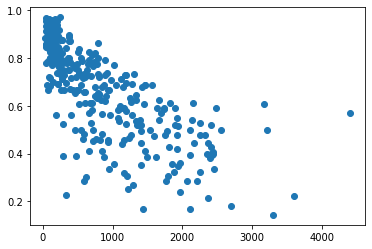

In [66]:
plt.scatter(tmp_DIS,tmp_DECAY)
scipy.stats.linregress(tmp_DIS,tmp_DECAY)

In [67]:
X = np.arange(1982,2019)
Y = []
for YEAR in X:
    tmp = []
    for CCC in range(len(tmp_SEASON)):
        if tmp_SEASON[CCC]==YEAR:
            tmp    .extend([tmp_DECAY[CCC]])
    Y.extend([np.nanmean(tmp)])
Y = np.asarray(Y)

In [68]:
tmp = pd.read_csv('./NINO34.csv')
ENSO = []
for RRR in range(len(tmp)):
    ENSO.append(np.mean(tmp.iloc[RRR,8:11]))
ENSO = np.asarray(ENSO)

In [69]:
scipy.stats.linregress(ENSO,scipy.signal.detrend(Y))

LinregressResult(slope=-0.029603907108904044, intercept=0.0010668074633844802, rvalue=-0.31675478340646257, pvalue=0.05611716222114584, stderr=0.014984166181067802)

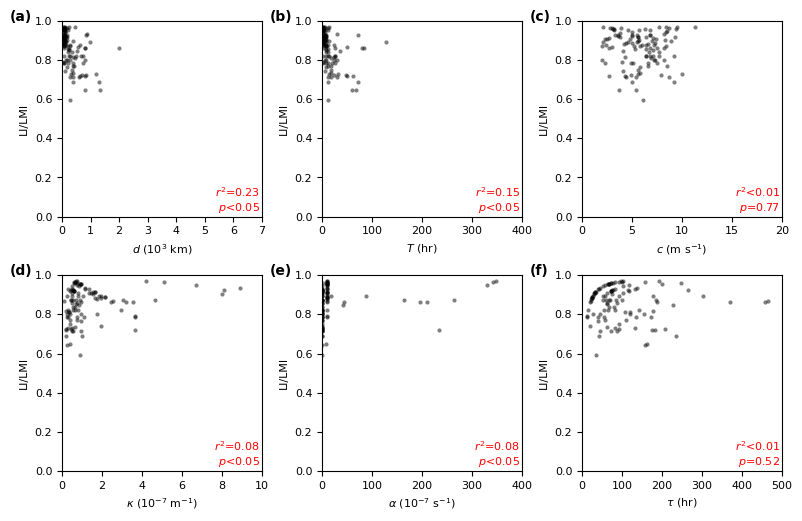

In [70]:
fig,ax=plt.subplots(2,3); fig.set_size_inches(8,5); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(100); 
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.3,hspace=0.3); fontsize = 8

interp_vmax_in_inverse = np.asarray(interp_vmax_in_inverse )
interp_vmax_pred_inverse = np.asarray(interp_vmax_pred_inverse)

MASK = []
for CCC in range(len(B_inverse)):
    if interp_vmax_in_inverse[CCC][-1] >= 96*.514444:
        MASK.extend([True])
    else:
        MASK.extend([False])
MASK=np.asarray(MASK)

dis_inverse = []
for CCC in range(len(VMAX_PMIN_SERIES)):
    dis_inverse.extend([VMAX_PMIN_SERIES[CCC][3]])
dis_inverse=np.asarray(dis_inverse)

# tmp_LMI and tmp_LF of individual cases with B_inverse case sequence
tmp_LILMI = []
for CCC in range(len(B_inverse)):
    tmp_LILMI.extend([interp_vmax_in_inverse[CCC][-1]/interp_vmax_in_inverse[CCC][ 0]])
tmp_LILMI=np.asarray(tmp_LILMI)
#
_=ax.flatten()[0].plot(trajectory_inverse[MASK]/1e3,tmp_LILMI[MASK],'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[0].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[0].set_ylabel('LI/LMI',fontsize=fontsize)
_=ax.flatten()[0].set_xlabel('$d$ (10$^3$ km)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_LILMI[MASK],trajectory_inverse[MASK])
p_str = str(np.round(p,2))
if p<0.05:
    p_str = '<0.05'
_=ax.flatten()[0].text(7*.99,1*.01,'$r^2$='+str('%.2f' %np.round(r**2,2))+'\n$p$'+p_str,fontsize=fontsize,va='bottom',ha='right',color='r')
_=ax.flatten()[0].text(-1.82,1,'(a)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[0].set_ylim([0,1])
_=ax.flatten()[0].set_xlim([0,7])
_=ax.flatten()[0].set_xticks(np.arange(0,8,1))
#
_=ax.flatten()[1].plot(dur_inverse[MASK],tmp_LILMI[MASK],'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[1].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[1].set_ylabel('LI/LMI',fontsize=fontsize)
_=ax.flatten()[1].set_xlabel('$T$ (hr)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_LILMI[MASK],dur_inverse[MASK])
p_str = str(np.round(p,2))
if p<0.05:
    p_str = '<0.05'
_=ax.flatten()[1].text(400*.99,1*.01,'$r^2$='+str('%.2f' %np.round(r**2,2))+'\n$p$'+p_str,fontsize=fontsize,va='bottom',ha='right',color='r')
_=ax.flatten()[1].text(-104,1,'(b)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[1].set_ylim([0,1])
_=ax.flatten()[1].set_xlim([0,400])
_=ax.flatten()[1].set_xticks(np.arange(0,401,100))
#
tmp = trajectory_inverse*1e3/(dur_inverse*3600)
_=ax.flatten()[2].plot(tmp[MASK],tmp_LILMI[MASK],'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[2].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[2].set_ylabel('LI/LMI',fontsize=fontsize)
_=ax.flatten()[2].set_xlabel('$c$ (m s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_LILMI[MASK],tmp[MASK])
p_str = '='+str('%.2f' %np.round(p,2))
if p<0.05:
    p_str = '<0.05'
r_str = '='+str('%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str='<0.01'
_=ax.flatten()[2].text(20*.99,1*.01,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='bottom',ha='right',color='r')
_=ax.flatten()[2].text(-5.2,1,'(c)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[2].set_ylim([0,1])
_=ax.flatten()[2].set_xlim([0,20])
_=ax.flatten()[2].set_xticks(np.arange(0,21,5))
#
DUR_AT_LEAST_POINTS = 0
#
Ref_B = 1.0e-7
B_latent=np.asarray(B_latent)
_=ax.flatten()[3].plot(B_latent[(dur_inverse>=DUR_AT_LEAST_POINTS)&(MASK)]/Ref_B,tmp_LILMI[(dur_inverse>=DUR_AT_LEAST_POINTS)&(MASK)],'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[3].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[3].set_ylabel('LI/LMI',fontsize=fontsize)
_=ax.flatten()[3].set_xlabel('$κ$ (10$^{-7}$ m$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_LILMI[(~np.isnan(B_latent))&(dur_inverse>=DUR_AT_LEAST_POINTS)&(MASK)],B_latent[(~np.isnan(B_latent))&(dur_inverse>=DUR_AT_LEAST_POINTS)&(MASK)])
p_str = '='+str('%.2f' %np.round(p,2))
if p<0.05:
    p_str = '<0.05'
r_str = '='+str('%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str='<0.01'
_=ax.flatten()[3].text(10*.99,1*.01,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='bottom',ha='right',color='r')
_=ax.flatten()[3].text(-2.6,1,'(d)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[3].set_ylim([0,1])
_=ax.flatten()[3].set_xlim([0,10])
_=ax.flatten()[3].set_xticks(np.arange(0,11,2))
#
Ref_B = 1.0e-7
C_latent=np.asarray(C_latent)
_=ax.flatten()[4].plot(C_latent[(dur_inverse>=DUR_AT_LEAST_POINTS)&(MASK)]/Ref_B,tmp_LILMI[(dur_inverse>=DUR_AT_LEAST_POINTS)&(MASK)],'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[4].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[4].set_ylabel('LI/LMI',fontsize=fontsize)
_=ax.flatten()[4].set_xlabel('$α$ (10$^{-7}$ s$^{-1}$)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_LILMI[(~np.isnan(B_latent))&(dur_inverse>=DUR_AT_LEAST_POINTS)&(MASK)],C_latent[(~np.isnan(B_latent))&(dur_inverse>=DUR_AT_LEAST_POINTS)&(MASK)])
p_str = '='+str('%.2f' %np.round(p,2))
if p<0.05:
    p_str = '<0.05'
r_str = '='+str('%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str='<0.01'
_=ax.flatten()[4].text(400*.99,1*.01,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='bottom',ha='right',color='r')
_=ax.flatten()[4].text(-104,1,'(e)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[4].set_ylim([0,1])
_=ax.flatten()[4].set_xlim([0,400])
_=ax.flatten()[4].set_xticks(np.arange(0,401,100))
#
dur_exp = np.asarray(dur_exp)
B_exp=np.asarray(B_exp)
_=ax.flatten()[5].plot(1/(B_exp[(dur_exp>=DUR_AT_LEAST_POINTS)&(MASK)]),tmp_LILMI[(dur_exp>=DUR_AT_LEAST_POINTS)&(MASK)],'o',color='k',ms=3,alpha=.5,mec='none')
_=ax.flatten()[5].tick_params(axis='both', which='major', labelsize=fontsize)
_=ax.flatten()[5].set_ylabel('LI/LMI',fontsize=fontsize)
_=ax.flatten()[5].set_xlabel('$τ$ (hr)',fontsize=fontsize)
_,_,r,p,_ = scipy.stats.linregress(tmp_LILMI[(~np.isnan(B_exp))&(dur_exp>=DUR_AT_LEAST_POINTS)&(MASK)],B_exp[(~np.isnan(B_exp))&(dur_exp>=DUR_AT_LEAST_POINTS)&(MASK)])
p_str = '='+str('%.2f' %np.round(p,2))
if p<0.05:
    p_str = '<0.05'
r_str = '='+str('%.2f' %np.round(r**2,2))
if r**2<0.01:
    r_str='<0.01'
_=ax.flatten()[5].text(500*.99,1*.01,'$r^2$'+r_str+'\n$p$'+p_str,fontsize=fontsize,va='bottom',ha='right',color='r')
_=ax.flatten()[5].text(-130,1,'(f)',fontsize=fontsize+2,fontweight='bold')
_=ax.flatten()[5].set_ylim([0,1])
_=ax.flatten()[5].set_xlim([0,500])
_=ax.flatten()[5].set_xticks(np.arange(0,501,100))
#
plt.savefig('/home/sw1013/www/FIGURES/Decay_Figure_2.png',dpi=600,bbox_inches='tight')
plt.savefig('/home/sw1013/www/FIGURES/Decay_Figure_2.pdf',dpi=600,bbox_inches='tight')

In [71]:
tmp_LI,tmp_LMI = [],[]
for CCC in range(len(B_inverse)):
    tmp_LI .extend([interp_vmax_in_inverse[CCC][-1]])
    tmp_LMI.extend([interp_vmax_in_inverse[CCC][ 0]])
tmp_LI,tmp_LMI=np.asarray(tmp_LI),np.asarray(tmp_LMI)

scipy.stats.linregress(tmp_LMI,tmp_LI)
scipy.stats.linregress(tmp_LI ,trajectory_inverse)

LinregressResult(slope=0.5070272001375636, intercept=9.864225873952794, rvalue=0.5247174754946685, pvalue=9.653647898962803e-49, stderr=0.03180264804667309)

LinregressResult(slope=-24.13948228713342, intercept=1586.2860279818733, rvalue=-0.3894942395381868, pvalue=9.858858006522604e-26, stderr=2.2069226511202484)